# <center>Data Mining Project Code</center>

** **
## <center>*Product Data Segmentation*</center>

** **

In this notebook, we aim to understand customer behaviors and preferences by clustering them based on their purchasing habits. By segmenting customers according to the characteristics of their purchasing patterns—such as the number of products they buy, the variety of vendors they source from, and whether they shop from chain stores—we can uncover valuable insights into their consumption behavior. This analysis allows businesses to tailor marketing strategies, optimize inventory, and offer personalized recommendations, ultimately enhancing the customer experience.

The primary goal of this notebook is to apply unsupervised learning techniques to identify distinct customer groups based on their purchasing patterns. We will utilize clustering algorithms such as KMeans, Hierarchical Clustering, Self-Organizing Maps (SOM), and Density-Based Clustering (DBSCAN) to form these groups. The quality of clustering will be evaluated using metrics like R², Silhouette Score, and the Calinski-Harabasz Index.

At the conclusion of this analysis, we will compare the results of different clustering approaches and identify the best-performing solution. We will then create detailed customer profiles for each segment and interpret their characteristics. These insights can provide actionable strategies for businesses to improve customer satisfaction and streamline their operations.


The members of the `team` are:
- Ana Farinha  - 20211514
- António Oliveira - 20211595
- Mariana Neto - 20211527
- Salvador Domingues - 20240597


# ToC

<a class="anchor" id="top"></a>


1. [Importing Libraries & Data](#1.-Importing-Libraries-&-Data) <br><br>

2. [Clustering](#2.-Clustering) <br>

    2.1 [Hierarchical Clustering](#2.1-Hierarchical-Clustering) <br><br>
    2.2 [K-Means](#2.2-K-Means) <br><br>
    2.3 [Self Organising Maps (SOM)](#2.4-Self-Organising-Maps-(SOM)) <br><br>
    2.4 [Density-based Clustering](#2.4-Density-based-Clustering) <br>
    
    &emsp; 2.4.1 [Meanshift](#2.4.1-Meanshift)<br><br>
    &emsp; 2.4.2 [DBScan](#2.4.2-Density-Based-Spatial-Clustering-of-Applications-with-Noise-(DBSCAN))<br><br>
    &emsp; 2.4.3 [HDBScan](#2.4.3-HDBScan)<br><br>
    &emsp; 2.4.4 [Gaussian Mixture Model (GMM)](#2.3.4-Gaussian-Mixture-Model-(GMM)) <br><br>
    
3. [Model Combination](#3.-Model-Combination) <br>

    3.1 [SOM + K-Means](#3.1-SOM-+-K-Means) <br><br>

4. [Model Comparison](#4.-Model-Comparison)

# 1. Importing Libraries & Data

In [12]:
import pandas as pd
import numpy as np
from IPython.display import display 

# Scalers
from sklearn.preprocessing import RobustScaler, StandardScaler, \
                                  MinMaxScaler

# Clustering algorithms
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import MeanShift, DBSCAN, estimate_bandwidth
from hdbscan import HDBSCAN
from sklearn.mixture import GaussianMixture
from minisom import MiniSom
from sklearn.neighbors import NearestNeighbors
import umap.umap_ as umap

# Segmentation
import segmentation as s

# Visualizations
import matplotlib.pyplot as plt
import functions as f

pd.set_option('display.max_columns', None)

# Suppress Warnings
import warnings
warnings.filterwarnings("ignore")

path = './plots/product_vendor/'

In [2]:
data = pd.read_csv('data/preprocessed_data.csv', 
                   index_col = "customer_id")
product_data = data[s.product_vendor]
product_data

vendor_count  product_count  is_chain
customer_id                                       
1b8f824d5e              2              5         1
5d272b9dcb              2              2         2
f6d1b2ba63              1              2         2
180c632ed8              2              3         1
4eb37a6705              2              5         0
...                   ...            ...       ...
f4e366c281              1              1         1
f6b6709018              1              1         0
f74ad8ce3f              1              1         1
f7b19c0241              1              1         0
fd40d3b0e0              1              1         0

[31828 rows x 3 columns]

In [3]:
product_data.drop(['product_count'], axis = 1, inplace = True)

# 2. Clustering

In [5]:
product_data_scaled = MinMaxScaler().fit_transform(product_data)

In [6]:
product_data_scaled = pd.DataFrame(product_data_scaled, 
                           columns=product_data.columns, 
                           index=product_data.index)

## 2.1 Hierarchical Clustering

To develop a clustering solution using hierarchical clustering, the following steps were carried out:

**1. Creating Dendrograms for All Combinations**
- Dendrograms were generated for all combinations of linkage methods (e.g., single, complete, average, ward) and distance metrics (e.g., Euclidean, Manhattan).
- This step provided a visual representation of the clustering hierarchy to understand how clusters merge at different thresholds.
- The dendrograms were analysed to identify configurations that produced distinct and meaningful clusters.

**2. Selecting the Best Combinations**
- Based on the dendrograms, the most promising combinations of linkage methods and distance metrics were shortlisted.
- The selection was based on:
  - Clear separation of clusters (visible gaps in the dendrograms).
  - Avoidance of configurations that produced excessive chaining effects or imbalanced clusters.
- This step narrowed the scope to the most viable configurations.

**3. Evaluating the Shortlisted Combinations**
- The shortlisted configurations were quantitatively evaluated using the following metrics:
  - **R² Score**: Measures how well the clustering structure explains the variance in the data. Higher values indicate a better-defined cluster structure.
  - **Silhouette Score**: Evaluates the compactness and separation of clusters. Scores range from -1 (poor clustering) to 1 (ideal clustering), providing insights into cluster quality.
  - **Calinski-Harabasz Score**: Assesses the ratio of the sum of cluster dispersion to inter-cluster distances. Higher values indicate well-separated and compact clusters.
- By leveraging these metrics, the combination of linkage methods and distance metrics producing the highest-quality clusters was identified and selected.

<a href="#top">Top &#129033;</a>

In [7]:
linkages=["complete", "average", "single", "ward"]

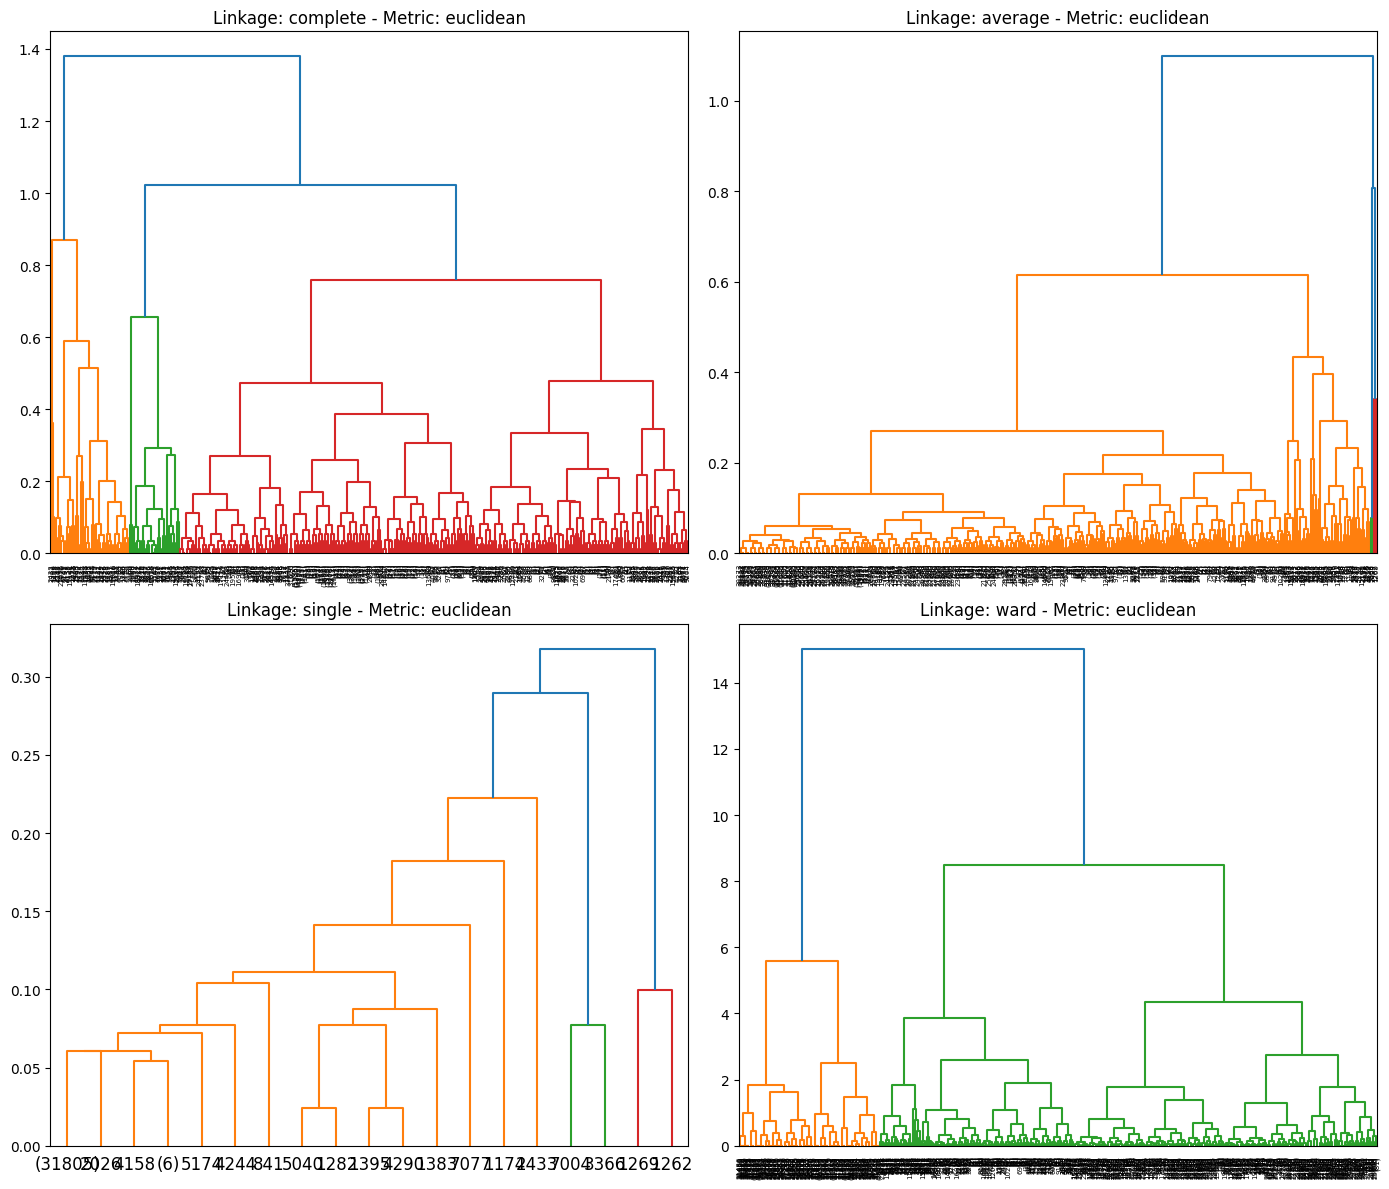

In [8]:
f.plot_hierarchical_dendrograms(product_data_scaled, path=path+'euclidean', linkages=linkages, metrics=['euclidean'])

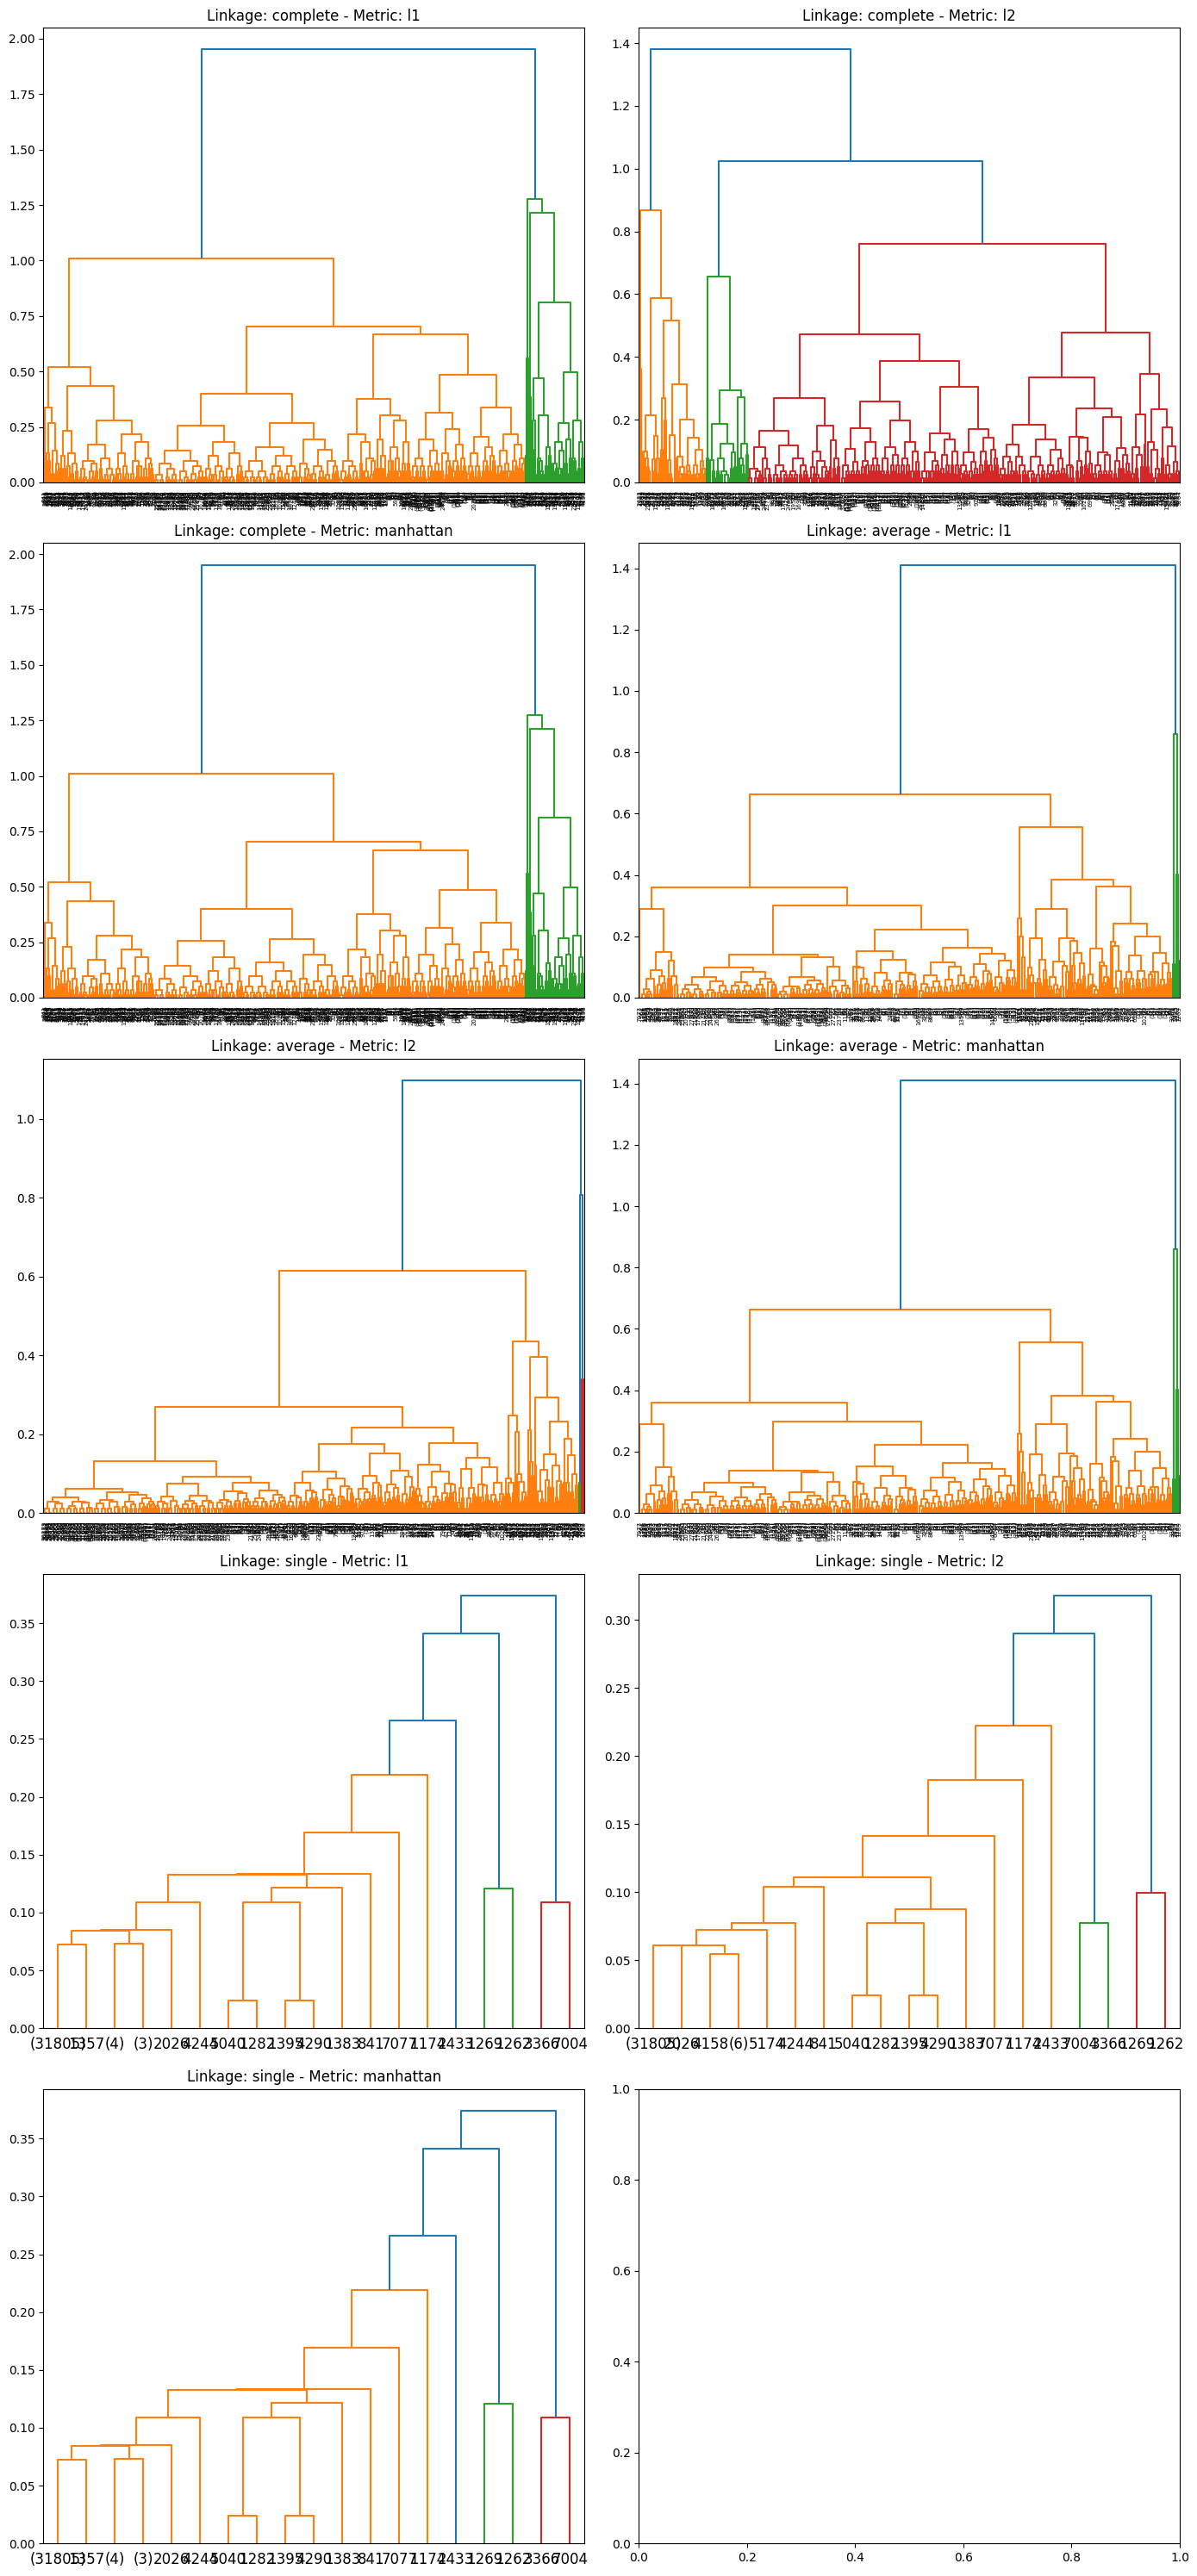

In [9]:
f.plot_hierarchical_dendrograms(product_data_scaled, path=path+'others', linkages=["complete", "average", "single"], metrics=['l1', 'l2', 'manhattan'])

In [10]:
hr_results = []

# Define clustering settings
cluster_settings = [
    {"model_type": "hierarchical", "n_clusters": k, "linkage": 'complete', "metric": 'euclidean'}
    for k in range(2, 8)  
] + [
    {"model_type": "hierarchical", "n_clusters": k, "linkage": 'ward', "metric": 'euclidean'}
    for k in range(2, 6)
] + [
    {"model_type": "hierarchical", "n_clusters": k, "linkage": 'complete', "metric": 'l1'}
    for k in range(2, 6) 
]

# Loop over settings and evaluate models
for settings in cluster_settings:
    result = f.create_and_evaluate_model(df=product_data_scaled, feats=product_data_scaled.columns.tolist(), **settings)
    hr_results.append(result)

# Convert results to DataFrame
hr_results_df = pd.DataFrame(hr_results)
hr_results_df

Model  n_clusters   linkage     metric        R2  Silhouette  \
0   hierarchical           2  complete  euclidean  0.114591    0.873319   
1   hierarchical           3  complete  euclidean  0.144751    0.817022   
2   hierarchical           4  complete  euclidean  0.149589    0.816896   
3   hierarchical           5  complete  euclidean  0.370804    0.785406   
4   hierarchical           6  complete  euclidean  0.373371    0.784796   
5   hierarchical           7  complete  euclidean  0.377546    0.784732   
6   hierarchical           2      ward  euclidean  0.516790    0.654405   
7   hierarchical           3      ward  euclidean  0.681251    0.631789   
8   hierarchical           4      ward  euclidean  0.752516    0.479276   
9   hierarchical           5      ward  euclidean  0.795664    0.482328   
10  hierarchical           2  complete         l1  0.128064    0.879099   
11  hierarchical           3  complete         l1  0.132726    0.872704   
12  hierarchical           4  complete         l1  0.136703    0.870757   
13  hierarchical           5  complete         l1  0.262540    0.815947   

    Calinski-Harabasz  
0         4118.960048  
1         2693.193132  
2         1865.971346  
3         4688.563994  
4         3792.166133  
5         3216.803278  
6        34037.709789  
7        34009.153243  
8        32255.293773  
9        30978.835573  
10        4674.402960  
11        2435.212126  
12        1679.777316  
13        2832.293816

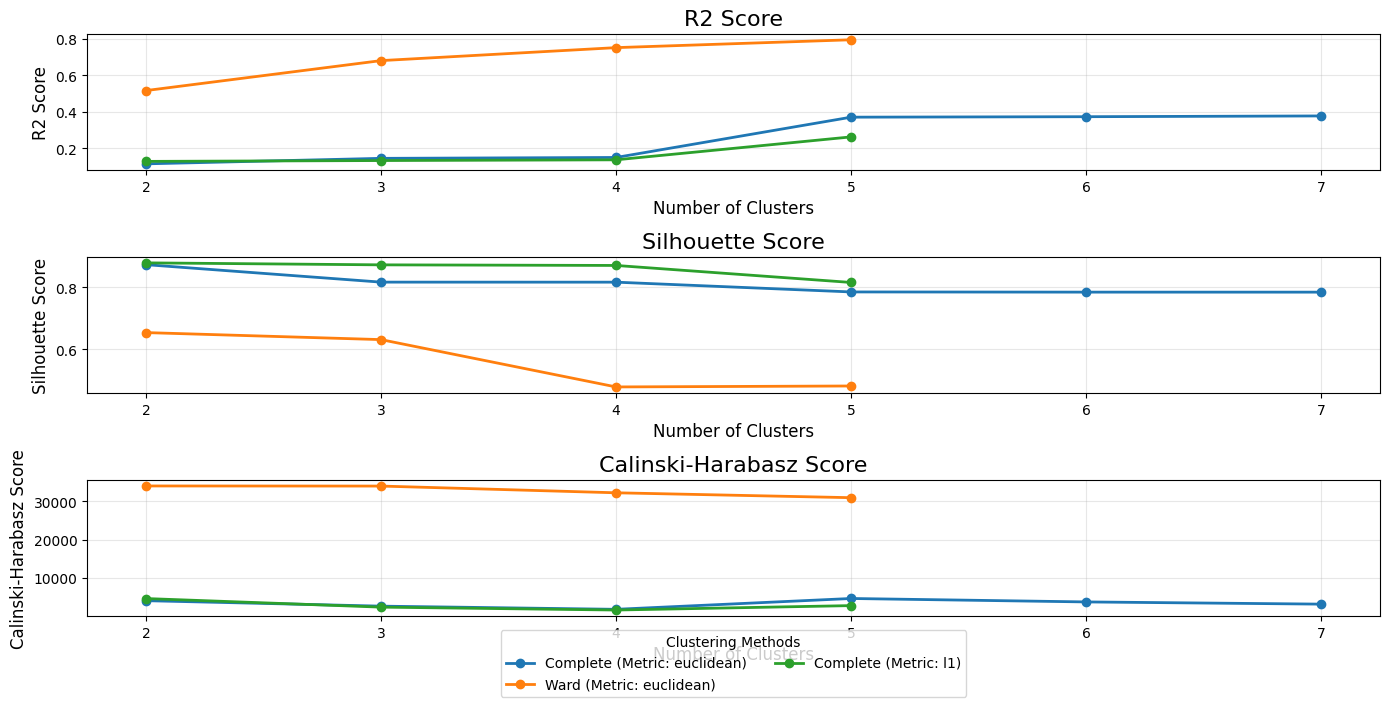

In [11]:
f.plot_evaluation_scores(hr_results_df, path)

**Final Model for Hierarchical Clustering**

In [21]:
linkage = 'ward'
distance = 'euclidean'
n_clusters = 4

hclust_w4 = AgglomerativeClustering(linkage=linkage, 
                                 metric=distance, 
                                 n_clusters=n_clusters)

hc_labels_w4 = hclust_w4.fit_predict(product_data_scaled)

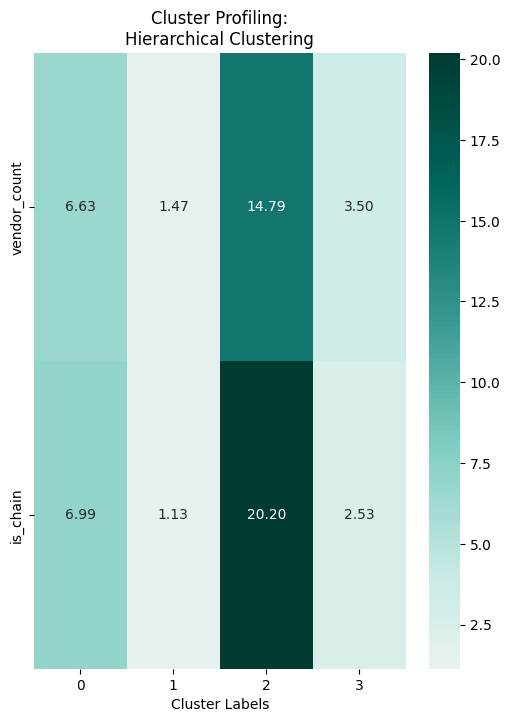

In [23]:
f.plot_cluster_profiling(product_data, hc_labels_w4, "Hierarchical")

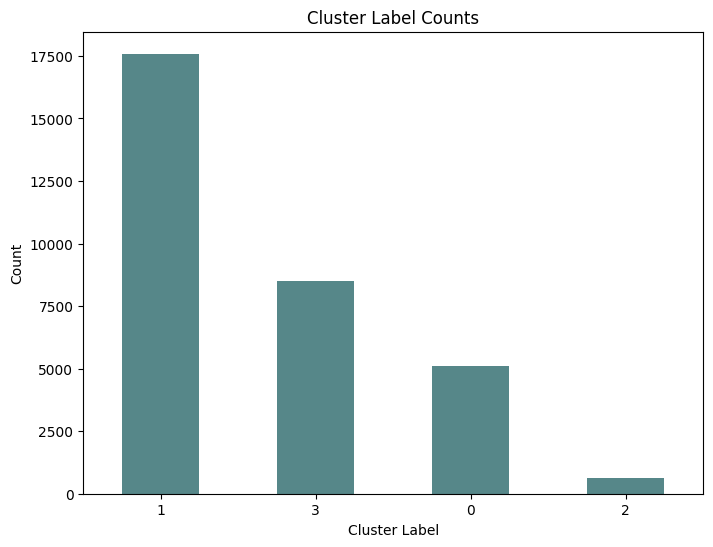

In [24]:
f.plot_counts(hc_labels_w4)

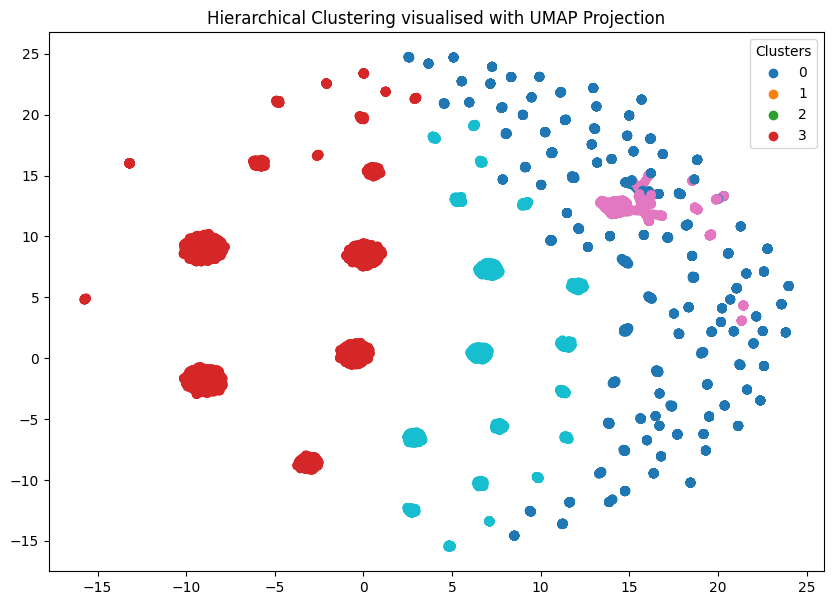

In [158]:
umap_object = umap.UMAP(n_neighbors = 10)

umap_embedding = umap_object.fit_transform(product_data_scaled)

f.plot_dim_reduction(umap_embedding, targets = hc_labels_w4,
                   technique = 'Hierarchical Clustering visualised with UMAP')

## 2.2 K-Means

<a href="#top">Top &#129033;</a>

To develop an optimal clustering solution using the K-Means algorithm, the following steps were carried out:

1. **Using the Elbow Method to Determine a Range for `n_clusters`**
- We began by using the **Elbow Method** to determine an appropriate range of values for the `n_clusters` hyperparameter.
- By plotting the within-cluster sum of squared distances (inertia) for a range of values of `n_clusters`, we identified the "elbow point," where increasing the number of clusters resulted in diminishing improvements to the inertia.
- This step provided a good initial estimate for the potential number of clusters and helped guide further testing.

2. **Evaluating Different `n_clusters` Values**
- After identifying a range of `n_clusters`, we evaluated different values of `n_clusters` based on various clustering quality metrics:
  - **R² Score**
  - **Silhouette Score**
  - **Calinski-Harabasz Score**
- These metrics allowed us to compare the effectiveness of each value for `n_clusters`, providing quantitative insights into cluster quality.

3. **Selecting the Optimal `n_clusters`**
- After evaluating multiple values for `n_clusters` with the metrics, we selected the value that showed the best balance across all three performance measures.
- This value provided the most meaningful and stable clusters, indicating that the K-Means algorithm was able to separate the data in a way that maximized clustering quality.
  
By focusing primarily on tuning `n_clusters`, we ensured that our clustering solution was optimized and tailored to the specific dataset, ultimately delivering high-quality, interpretable clusters.

**Elbow Method**

The **Elbow Method** is a technique used to determine the optimal number of clusters (`n_clusters`) for K-Means clustering. It involves plotting the within-cluster sum of squared distances (inertia) against different values of `n_clusters`. As the number of clusters increases, the inertia decreases, but at a certain point, the rate of improvement slows down. 

The "elbow" is the point on the plot where the inertia starts to level off, indicating that adding more clusters does not lead to significant improvements in clustering quality. This point suggests the optimal number of clusters to use for the dataset, balancing between overfitting and underfitting the model.


In [32]:
dispersion = []
for k in range(1, 20):
    kmeans = KMeans(n_clusters=k, random_state=24, max_iter=500, n_init=50).fit(product_data_scaled)
    dispersion.append(kmeans.inertia_)

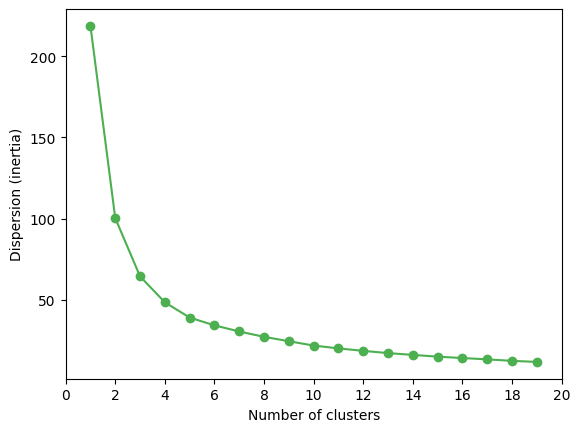

In [33]:
plt.plot(range(1, 20), dispersion, marker='o', color='#4CAF50')
plt.xlabel('Number of clusters')
plt.ylabel('Dispersion (inertia)')
plt.xticks(np.arange(0, 21, step=2))  
# plt.vlines(7, 5000, 600000, color='red')

plt.show()

Based on the elbow plot, the following conclusions can be drawn for the optimal number of clusters (`k`) for K-Means:

**Range: 3 to 8 Clusters**

- **Elbow Point**: The elbow point appears around 4 clusters, which suggests a good balance between minimizing dispersion and maintaining model simplicity.
- **Flattening**: After the elbow point, the plot flattens, indicating that increasing the number of clusters beyond 4 results in diminishing improvements in the clustering performance.
- **Overfitting Risk**: Using more than 8 clusters may lead to overfitting, as the model could start capturing noise in the data rather than the underlying patterns.

In [34]:
results_kmeans = []

# Define clustering settings
cluster_settings = [
    {"model_type": "kmeans", "n_clusters": k, 'random_state': 42, 'max_iter':500, 'n_init':50} for k in range(3, 8)
]

# Loop over settings and evaluate models
for settings in cluster_settings:
    result = f.create_and_evaluate_model(df=product_data_scaled, feats=product_data_scaled.columns.tolist(), **settings)
    results_kmeans.append(result)

# Convert results to DataFrame
results_kmeans_df = pd.DataFrame(results_kmeans)
results_kmeans_df

Model  n_clusters  random_state  max_iter  n_init        R2  Silhouette  \
0  kmeans           3            42       500      50  0.704553    0.593857   
1  kmeans           4            42       500      50  0.777788    0.515994   
2  kmeans           5            42       500      50  0.820483    0.499430   
3  kmeans           6            42       500      50  0.842477    0.484531   
4  kmeans           7            42       500      50  0.859514    0.486435   

   Calinski-Harabasz  
0       37946.493591  
1       37130.188216  
2       36361.681145  
3       34038.651267  
4       32447.512690

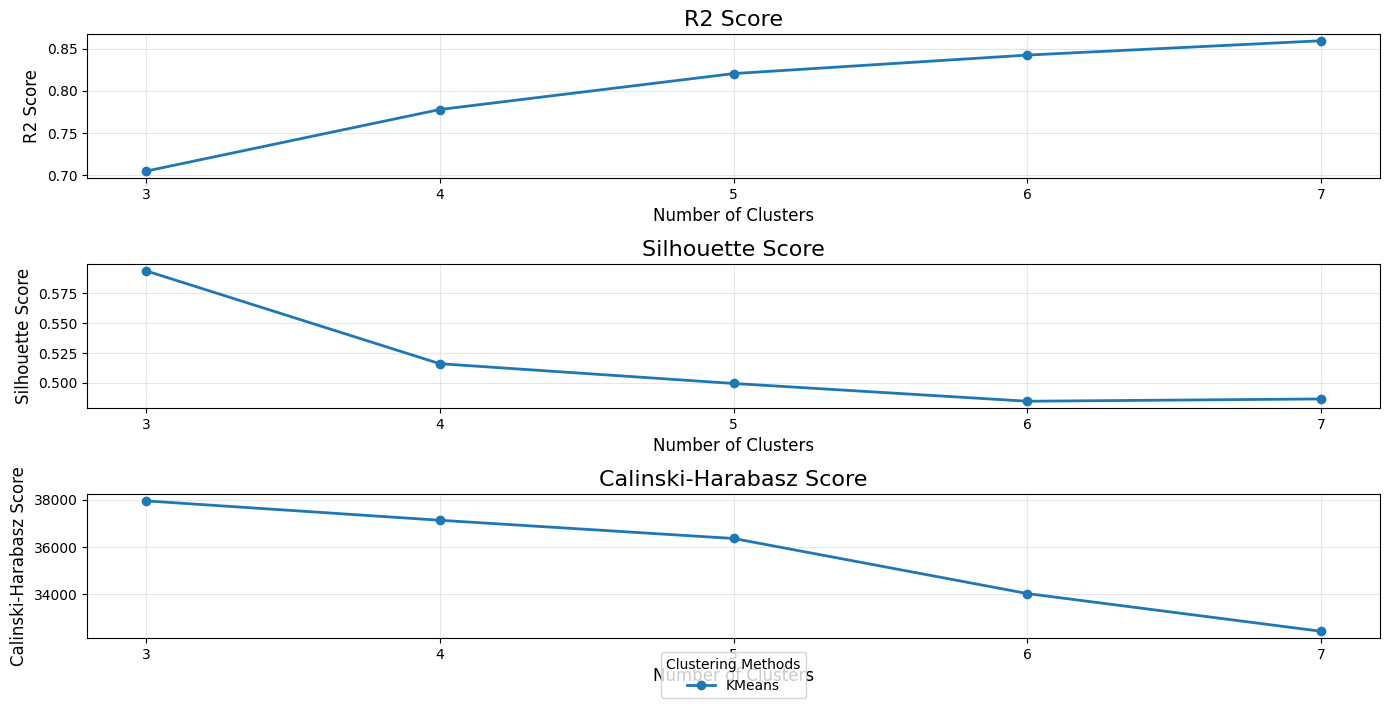

In [35]:
f.plot_evaluation_scores(results_kmeans_df, path)

**Final Model**

After evaluating multiple clustering models, we have shortlisted the best-performing model based on various metrics.

To further evaluate and compare the best two clustering models, we will examine their clustering solutions by profiling the clusters based on their feature means. We will use **Cluster Profiling** to visualize the mean values of the features for each cluster using a heatmap. The heatmap will highlight any significant patterns, differences between clusters, and overall cohesion within each group.

This approach will enable us to analyze and interpret the clustering solutions, making it easier to decide which model yields more meaningful and well-separated clusters.

By comparing the cluster profiles, we will be able to assess:
- The **separation** of clusters based on feature means.
- The **interpretability** of clusters based on how the features differ across them.

In [42]:
number_clusters = 4
kmclust4 = KMeans(n_clusters=number_clusters,
                  random_state=24,
                  max_iter=500, 
                  n_init=50)

km_labels4 = kmclust4.fit_predict(product_data_scaled)

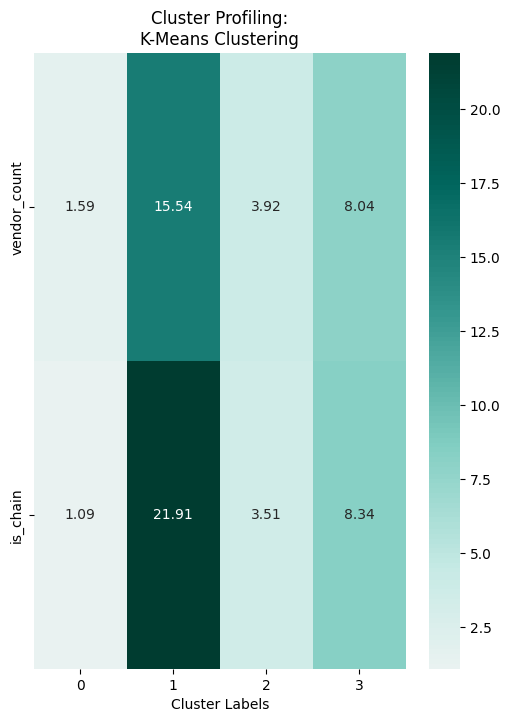

In [43]:
f.plot_cluster_profiling(product_data, km_labels4, "K-Means")

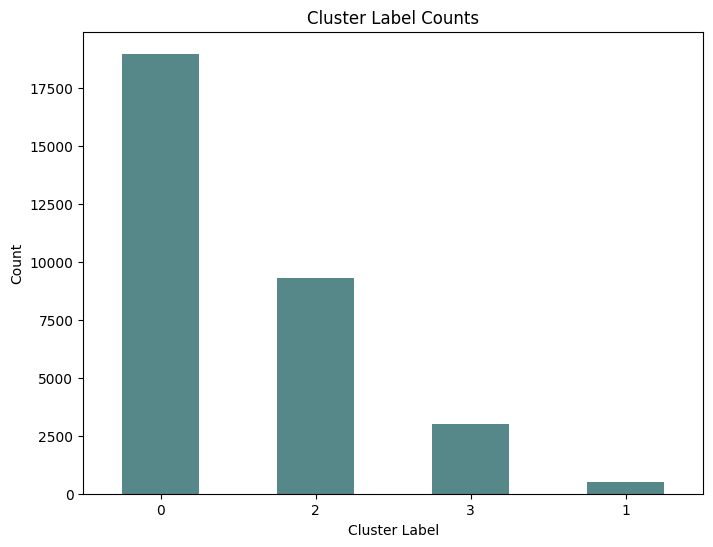

In [44]:
f.plot_counts(km_labels4)

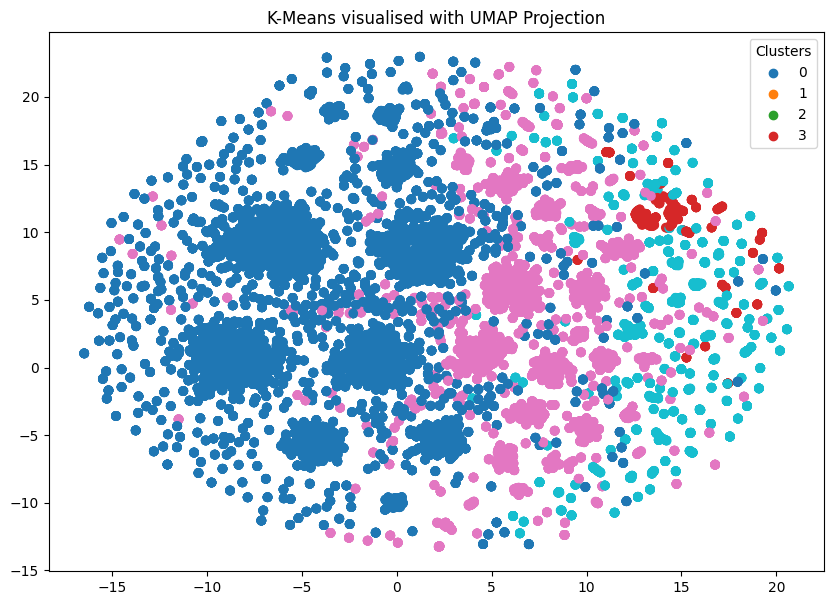

In [136]:
umap_object = umap.UMAP(n_neighbors = 5)
umap_embedding = umap_object.fit_transform(product_data_scaled)

f.plot_dim_reduction(umap_embedding, targets = km_labels4,
                   technique = 'K-Means visualised with UMAP')

## 2.3 Self Organising Maps (SOM)

<a href="#top">Top &#129033;</a>

To achieve an optimal clustering solution using the Self-Organizing Map (SOM), the following steps were conducted:

1. **Determining the Optimal Number of Iterations**

- The **Quantization Error** was tracked over a range of iterations (1 to 1000) to identify the optimal training duration.
- By plotting the quantization error, it was observed that the error stabilized between **650 and 750 iterations**, providing a suitable range for further evaluation.

2. **Evaluating Different SOM Configurations**

- Within the determined range of iterations, multiple SOM configurations were evaluated by varying key hyperparameters:

    - `x` and `y`: Grid dimensions, fixed at **15x15**.
    - `input_len`: The number of input features, matching the scaled dataset's column count.
    - `sigma`: Neighborhood function's standard deviation, set to **0.5**.
    - `learning_rate`: Tested values of **1.0**, **0.9**, and **0.8**.
    - `num_iterations`: Iteration counts from **650 to 750**, incremented by 10.

3. **Evaluating Model Performance**

- Each configuration was assessed using clustering quality metrics:
    - **R² Score**
    - **Silhouette Score**
    - **Calinski-Harabasz Index**

- The results were compiled into a DataFrame for comparison and visualized to observe the impact of `learning_rate` and `num_iterations` on clustering performance.

In [182]:
scaled_data_array = product_data_scaled.to_numpy()

In [183]:
som = MiniSom(
    15, 
    15, 
    len(product_data_scaled.columns),
    sigma=0.5,
    neighborhood_function='gaussian',
    learning_rate = 1,
    random_seed=42
    )

In [184]:
np.random.seed(42)

num_iterations = 1000

q_errors = []
for i in range(1, num_iterations):
    som.train_batch(scaled_data_array, i)
    q_errors.append(som.quantization_error(scaled_data_array))

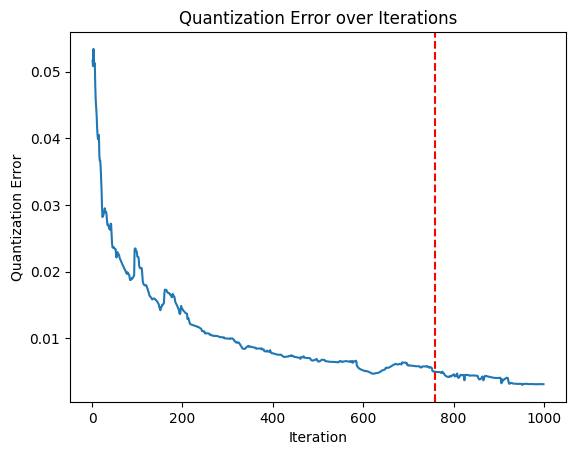

In [185]:
plt.plot(range(1, num_iterations), q_errors)
plt.title('Quantization Error over Iterations')
plt.xlabel('Iteration')
plt.ylabel('Quantization Error')
plt.axvline(x=760, color='red', linestyle='--')
plt.show()

In [189]:
som_results = []
learning_rate_lst = [1, 0.9, 0.8]

# Define clustering settings
cluster_settings = [
    {"model_type": "som", "x": 15, 'y': 15, 'input_len': len(product_data_scaled.columns),
     'sigma': 0.5, 'learning_rate': lr, 'num_iterations': k}
    for k in np.arange(650, 750, 10) 
    for lr in learning_rate_lst
]

# Loop over settings and evaluate models
for settings in cluster_settings:
    result = f.create_and_evaluate_model(df=scaled_data_array, feats=product_data_scaled.columns.tolist(), 
                                       **settings)
    som_results.append(result)

# Convert results to DataFrame
som_results_df = pd.DataFrame(som_results)
som_results_df

Model   x   y  input_len  sigma  learning_rate  num_iterations        R2  \
0    som  15  15          2    0.5            1.0             650  0.830012   
1    som  15  15          2    0.5            0.9             650  0.885885   
2    som  15  15          2    0.5            0.8             650  0.858448   
3    som  15  15          2    0.5            1.0             660  0.876570   
4    som  15  15          2    0.5            0.9             660  0.862813   
5    som  15  15          2    0.5            0.8             660  0.802369   
6    som  15  15          2    0.5            1.0             670  0.887153   
7    som  15  15          2    0.5            0.9             670  0.848824   
8    som  15  15          2    0.5            0.8             670  0.861442   
9    som  15  15          2    0.5            1.0             680  0.867230   
10   som  15  15          2    0.5            0.9             680  0.871060   
11   som  15  15          2    0.5            0.8             680  0.843982   
12   som  15  15          2    0.5            1.0             690  0.877058   
13   som  15  15          2    0.5            0.9             690  0.873114   
14   som  15  15          2    0.5            0.8             690  0.813225   
15   som  15  15          2    0.5            1.0             700  0.901327   
16   som  15  15          2    0.5            0.9             700  0.900877   
17   som  15  15          2    0.5            0.8             700  0.845586   
18   som  15  15          2    0.5            1.0             710  0.891314   
19   som  15  15          2    0.5            0.9             710  0.895972   
20   som  15  15          2    0.5            0.8             710  0.871746   
21   som  15  15          2    0.5            1.0             720  0.865286   
22   som  15  15          2    0.5            0.9             720  0.900638   
23   som  15  15          2    0.5            0.8             720  0.846645   
24   som  15  15          2    0.5            1.0             730  0.899956   
25   som  15  15          2    0.5            0.9             730  0.862446   
26   som  15  15          2    0.5            0.8             730  0.865574   
27   som  15  15          2    0.5            1.0             740  0.903424   
28   som  15  15          2    0.5            0.9             740  0.893057   
29   som  15  15          2    0.5            0.8             740  0.857274   

    Silhouette  Calinski-Harabasz  
0     0.214691        5008.145413  
1     0.320128        9143.222229  
2     0.436725        8036.247302  
3     0.451651        8364.255203  
4     0.443771        8000.536181  
5     0.552290        5869.384552  
6     0.463521       11906.846399  
7     0.475210        8504.057620  
8     0.488366        8597.050308  
9     0.309810        7418.050031  
10    0.483245       10231.764629  
11    0.518282        6616.446376  
12    0.477090        9864.701467  
13    0.473137        7544.998581  
14    0.555353        6594.501064  
15    0.412221       12104.322133  
16    0.406301       12567.317823  
17    0.490423        8293.971245  
18    0.418015       10030.500033  
19    0.443247        9443.806687  
20    0.473923        7719.254958  
21    0.497071        9285.839874  
22    0.389878       12011.199113  
23    0.498184        6502.293439  
24    0.476113        9863.484278  
25    0.240819        7668.784024  
26    0.478324        8190.943368  
27    0.459742       10257.119694  
28    0.419671       10622.909188  
29    0.496817        7640.646912

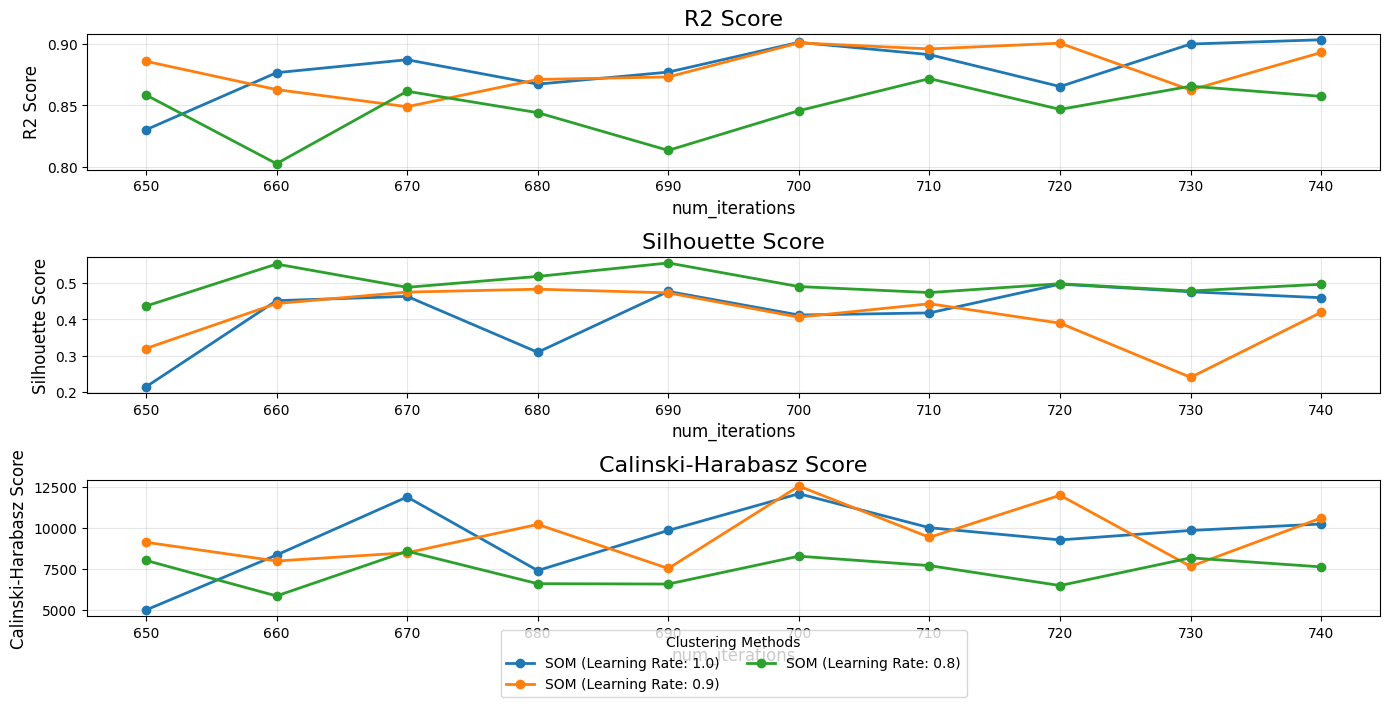

In [ ]:
f.plot_evaluation_scores(som_results_df, path+'som')

**Final Model for SOM**

In [192]:
som = MiniSom(
    15, 
    15, 
    len(product_data_scaled.columns),
    sigma=0.5,
    neighborhood_function='gaussian',
    learning_rate = 0.8,
    random_seed=42
    )

som.train(scaled_data_array, 700)

# Get the SOM grid size (rows and columns)
weights = som.get_weights()
som_rows, som_cols, _ = weights.shape  # Extracting the grid dimensions

# Get the winning node (BMU) for each data point
som_labels = np.array([som.winner(x) for x in scaled_data_array])

# Convert the 2D grid positions to 1D labels
som_labels_1d = [x[0] * som_cols + x[1] for x in som_labels]

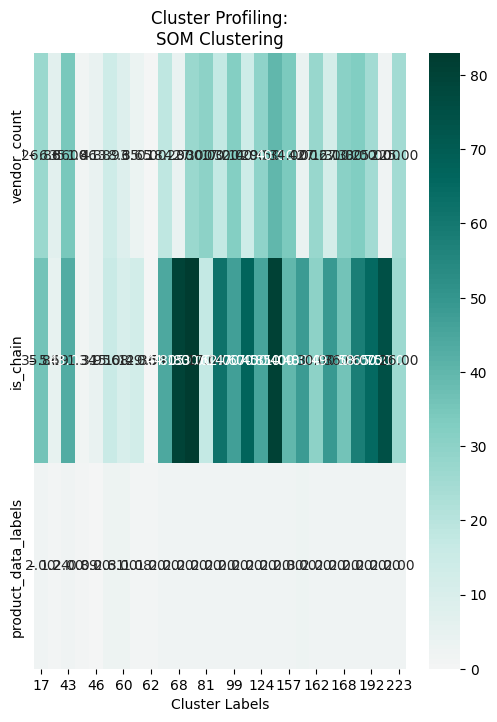

In [193]:
f.plot_cluster_profiling(product_data, som_labels_1d, "SOM")

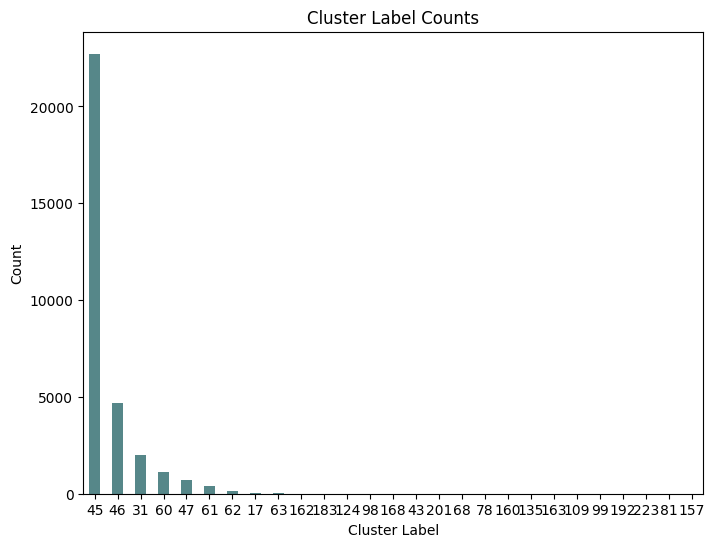

In [194]:
f.plot_counts(som_labels_1d)

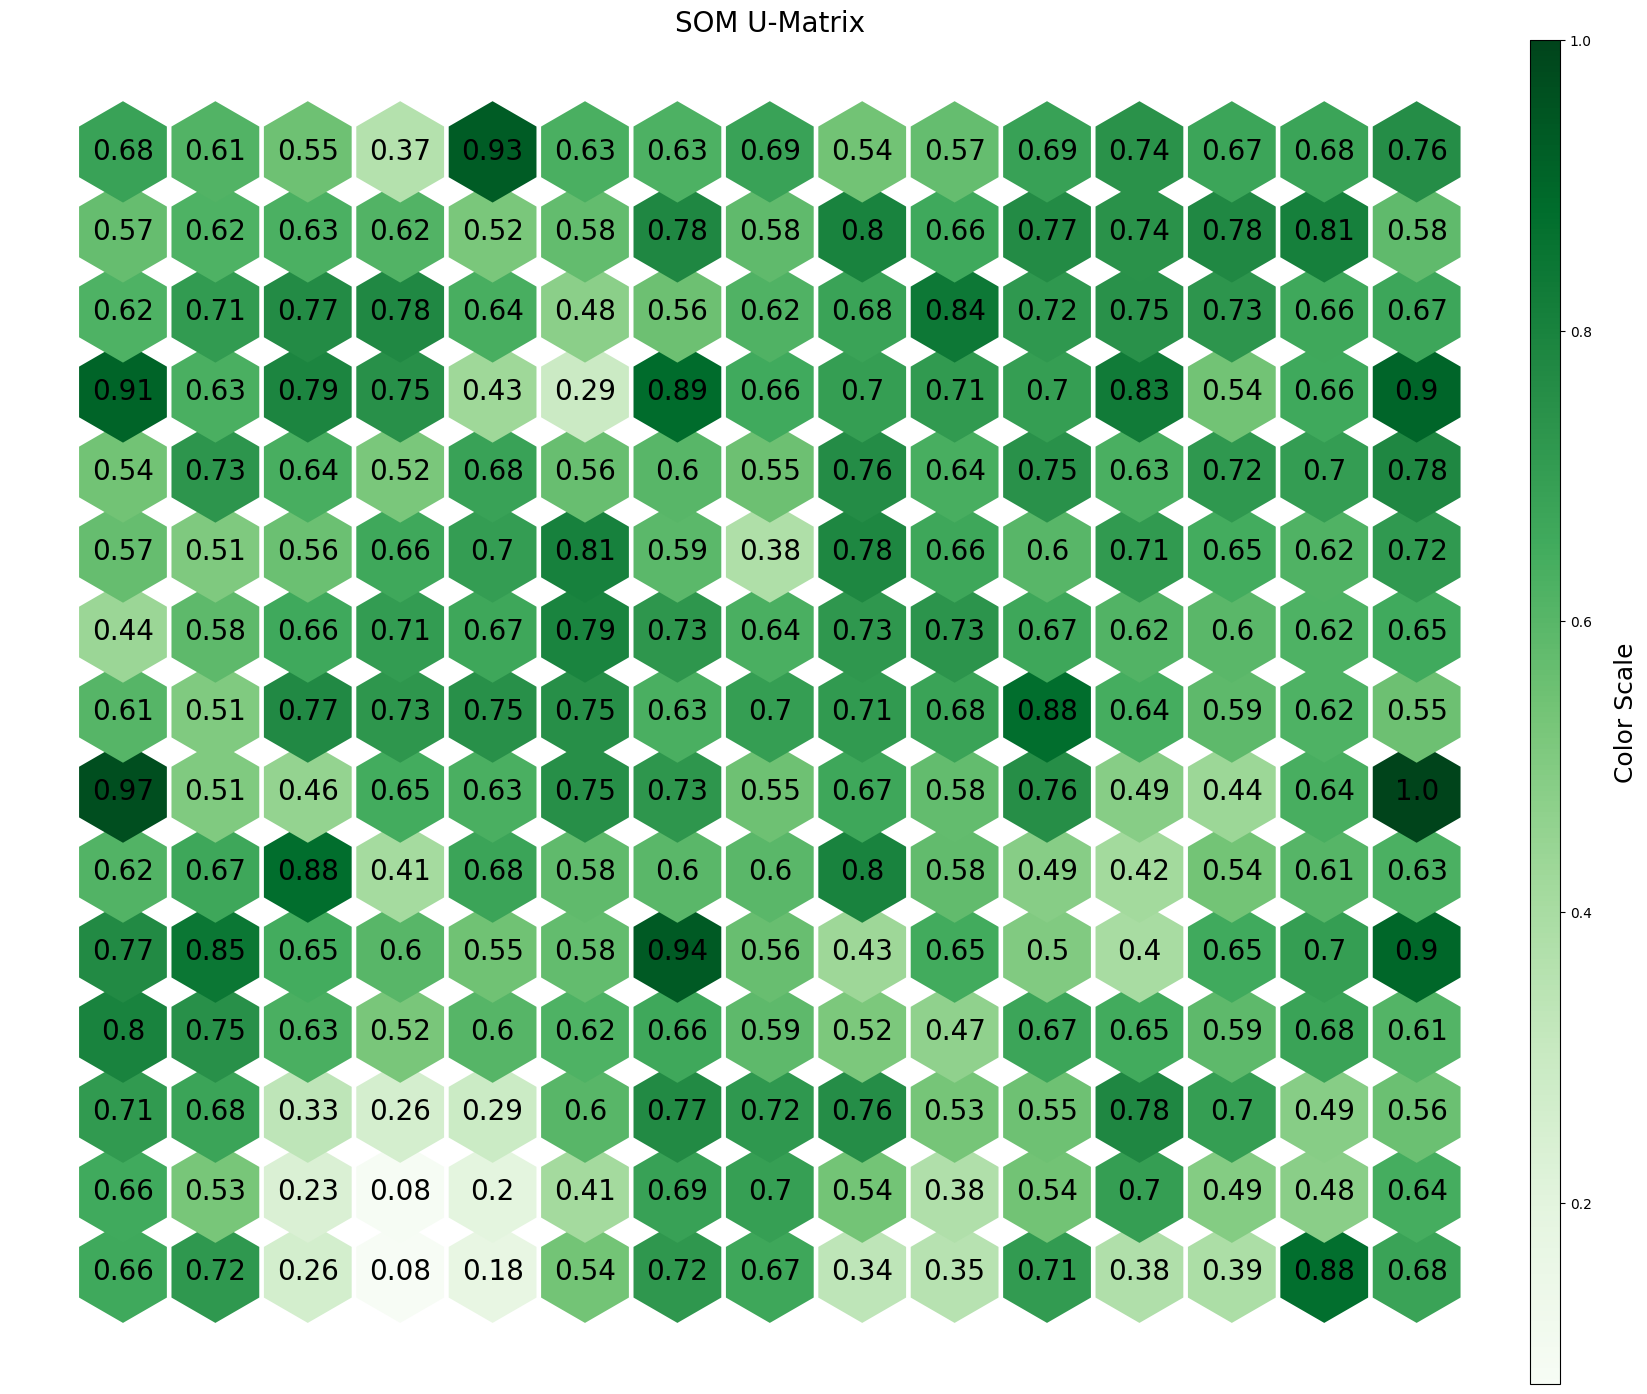

In [ ]:
umatrix = som.distance_map(scaling='mean')

fig = f.plot_som_hexagons(som, umatrix, 
                          cmap=cm.Greens, 
                          title="SOM U-Matrix")
plt.show()

**Retrain SOM**

After analysing the Error Plot, we decided to retrain our previously defined SOM model with **XXX** iterations.

In [ ]:
som.train(scaled_data_array, 770)

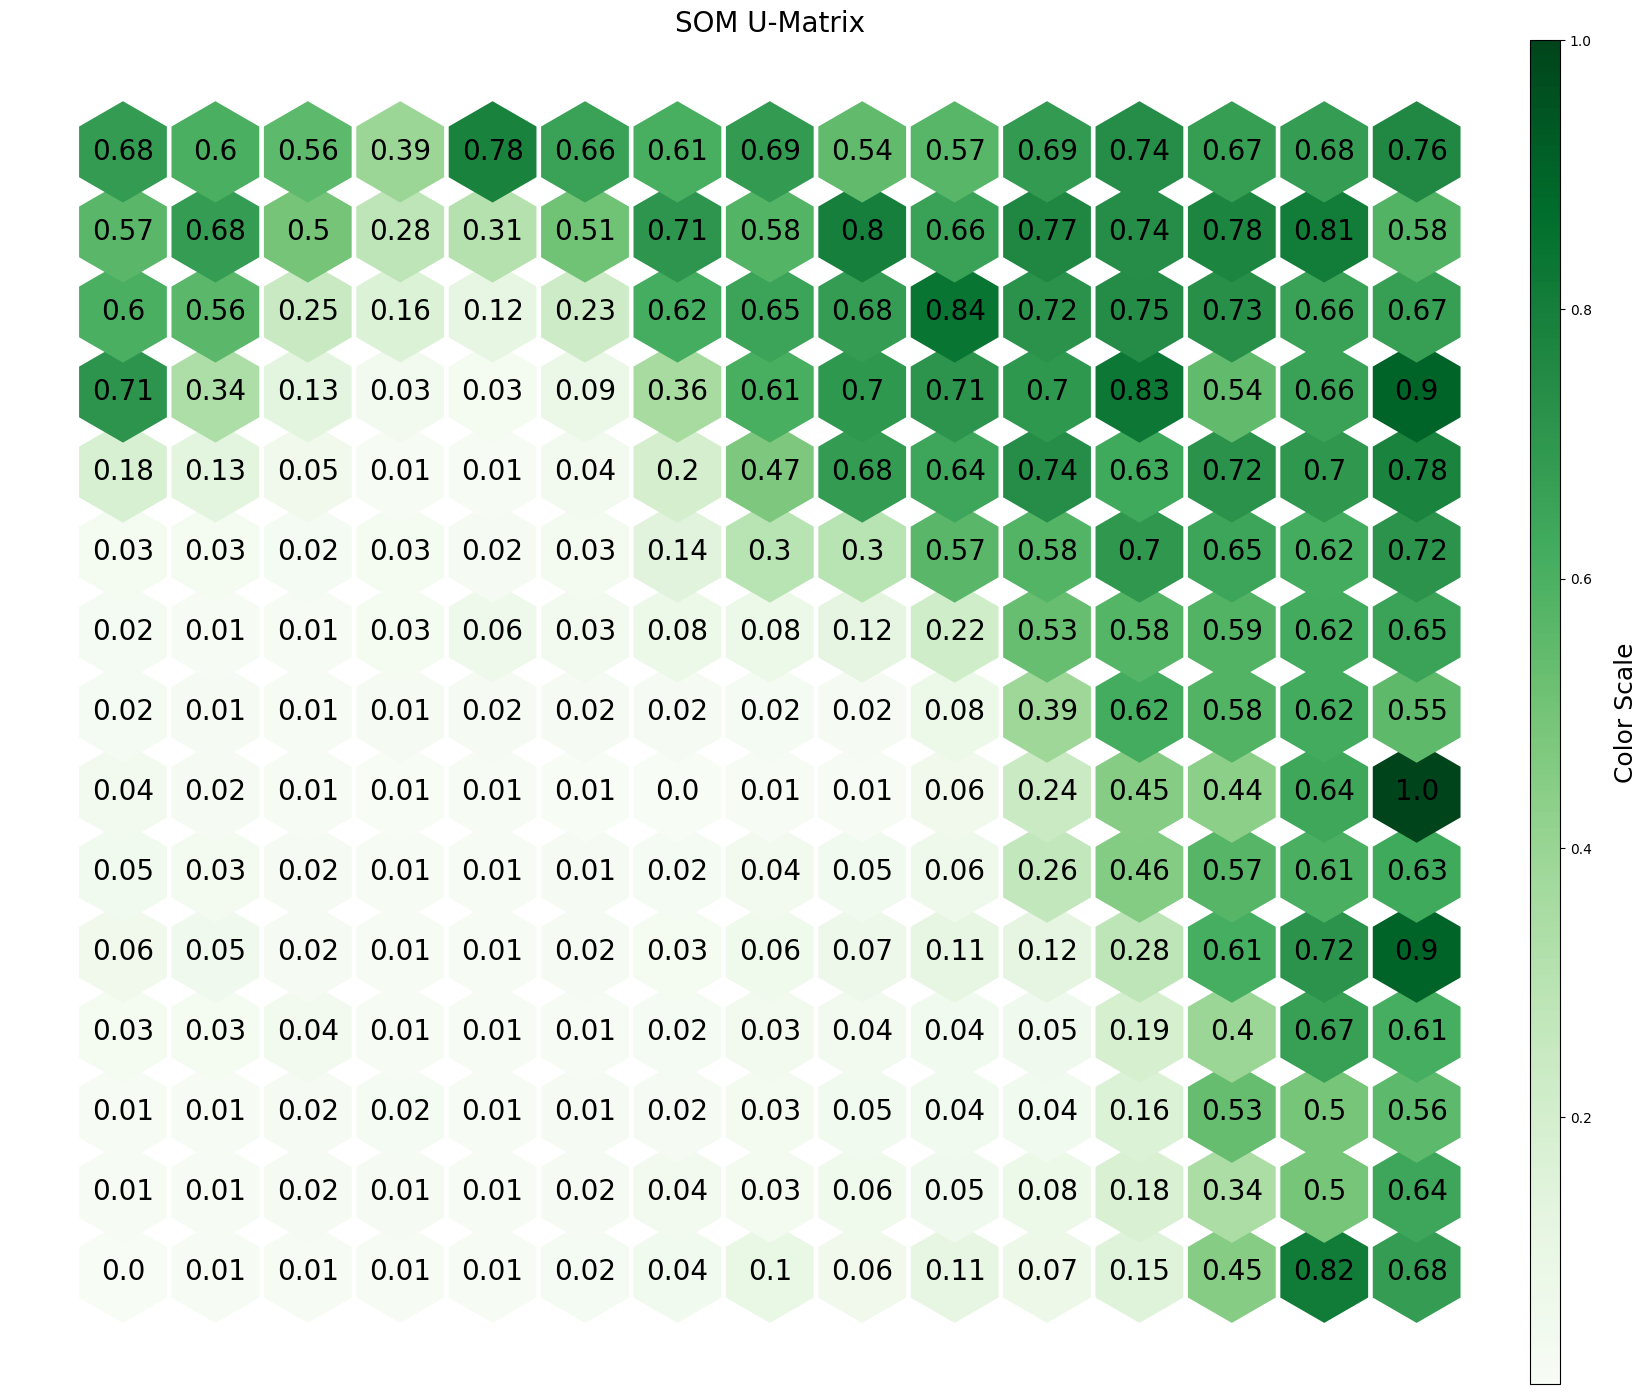

In [ ]:
umatrix = som.distance_map(scaling='mean')

fig = f.plot_som_hexagons(som, umatrix, 
                          cmap=cm.Greens, 
                          title="SOM U-Matrix")
plt.show()

## 2.4 Density-based Clustering

<a href="#top">Top &#129033;</a>

### 2.4.1 MeanShift

<a href="#top">Top &#129033;</a>

To achieve an optimal clustering solution using the MeanShift algorithm, the following steps were conducted:

1. **Estimating the Bandwidth Parameter**

- The estimate_bandwidth function was applied to the scaled dataset to calculate an optimal bandwidth value for Mean Shift clustering. This parameter controls the size of the neighborhood used to determine the density of data points.

2. Evaluating Different MeanShift Configurations

- With the estimated bandwidth, multiple configurations of the MeanShift algorithm were tested by varying key hyperparameters:
    - bandwidth: Fixed at 0.65 based on the estimation step.
    - cluster_all: Tested both True and False to explore whether all points should be assigned to clusters.
    - min_bin_freq: Minimum bin frequency values were evaluated from 1 to 5, controlling the minimum number of points in a bin to consider it a cluster.

Each configuration was evaluated for its ability to produce meaningful and distinct clusters.

The combinations were then evaluated using the same metrics previously explained:
- R² Score.
- Silhouette Score.
- Calinski-Harabasz Score.

At the end, we choose our best MeanShift solution.

**Estimate Bandwidth**

In [169]:
bandwidth = estimate_bandwidth(product_data_scaled, quantile=0.5, random_state=42)
bandwidth

0.060811218106116

In [170]:
# Perform mean-shift clustering with bandwidth set using estimate_bandwidth
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms_labels = ms.fit_predict(product_data_scaled)

ms_n_clusters = len(np.unique(ms_labels))
print("Number of estimated clusters : %d" % ms_n_clusters)

Number of estimated clusters : 25


In [171]:
ms_results = []

# Define clustering settings
cluster_settings = [
    {"model_type": "meanshift", 'bandwidth': bandwidth, 
     'cluster_all': True, 'min_bin_freq': k}
    for k in range(1, 5)  
] + [
    {"model_type": "meanshift", 'bandwidth': bandwidth, 
     'cluster_all': False, 'min_bin_freq': k}
    for k in range(1, 5)  
] 
# Loop over settings and evaluate models
for settings in cluster_settings:
    result = f.create_and_evaluate_model(df=product_data_scaled, feats=product_data_scaled.columns.tolist(), **settings)
    ms_results.append(result)

# Convert results to DataFrame
ms_results_df = pd.DataFrame(ms_results)
ms_results_df

Model  bandwidth  cluster_all  min_bin_freq        R2  Silhouette  \
0  meanshift   0.060811         True             1  0.564687    0.697997   
1  meanshift   0.060811         True             2  0.564687    0.697997   
2  meanshift   0.060811         True             3  0.564687    0.697997   
3  meanshift   0.060811         True             4  0.564687    0.697997   
4  meanshift   0.060811        False             1  0.675101    0.614203   
5  meanshift   0.060811        False             2  0.675101    0.614203   
6  meanshift   0.060811        False             3  0.675101    0.614203   
7  meanshift   0.060811        False             4  0.675101    0.614203   

   Calinski-Harabasz  
0        1473.197618  
1        1473.197618  
2        1473.197618  
3        1473.197618  
4        2278.356736  
5        2278.356736  
6        2278.356736  
7        2278.356736

In [172]:
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
mslabels = ms.fit_predict(product_data_scaled)

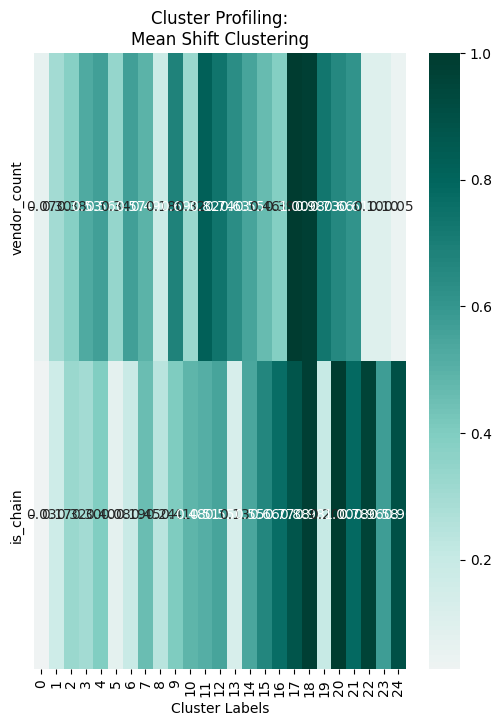

In [173]:
f.plot_cluster_profiling(product_data_scaled, mslabels, "Mean Shift")

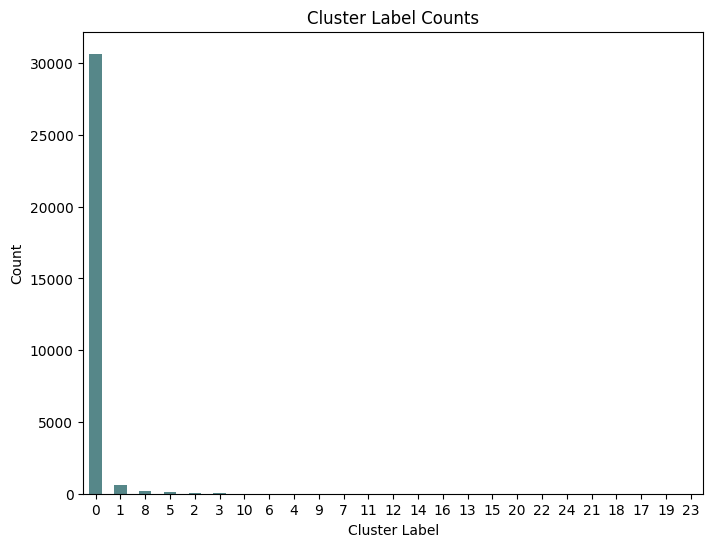

In [174]:
f.plot_counts(mslabels)

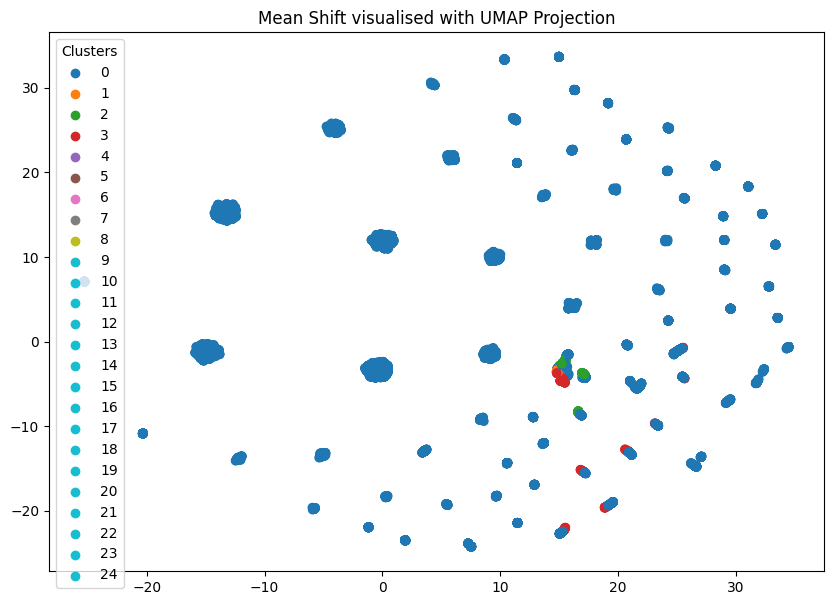

In [175]:
umap_object = umap.UMAP(n_neighbors = 50)
umap_embedding = umap_object.fit_transform(product_data_scaled)

f.plot_dim_reduction(umap_embedding, targets = mslabels,
                   technique = 'Mean Shift visualised with UMAP')

### 2.4.2 Density-Based Spatial Clustering of Applications with Noise (DBSCAN)

<a href="#top">Top &#129033;</a>

To initialize the DBSCAN clustering algorithm, we first constructed a **K-Distance Graph** to determine an appropriate range for the `eps` hyperparameter. The elbow point in the graph provided a starting point for selecting potential values of `eps`.

With the range of `eps` values suggested by the plot, we tested several combinations of hyperparameters, including:  
- Different values for `eps`.  
- Different algorithm types (`'ball_tree'`, `'kd_tree'`, `'brute'`).  

The combinations were then evaluated using the same metrics previously explained:
- **R² Score**.  
- **Silhouette Score**.  
- **Calinski-Harabasz Score**.

At the end, we choose our best dbscan solution.


**Optimimising *Eps* Parameter**

To determine the optimal value for the `eps` parameter in **DBSCAN**, we started by constructing a **K-Distance Graph**. This approach helps visualize the distances to the k-th nearest neighbour for all points in the dataset and guides us in selecting an appropriate `eps` value. The **`eps` (epsilon)** parameter determines the maximum distance between two points to classify them as part of the same cluster in DBSCAN. 



The **K-Distance Graph** plots the sorted distances to each point’s k-th nearest neighbour. By observing the graph:

1. Look for the **elbow point** in the curve. 
   - This is the region where the distances transition from a gradual increase to a sharp rise. 
   - The elbow indicates the maximum distance within a cluster before reaching outliers.

2. Select an `eps` value slightly larger than the distance at the elbow.
   - This ensures all points within dense clusters are captured without including many outliers.


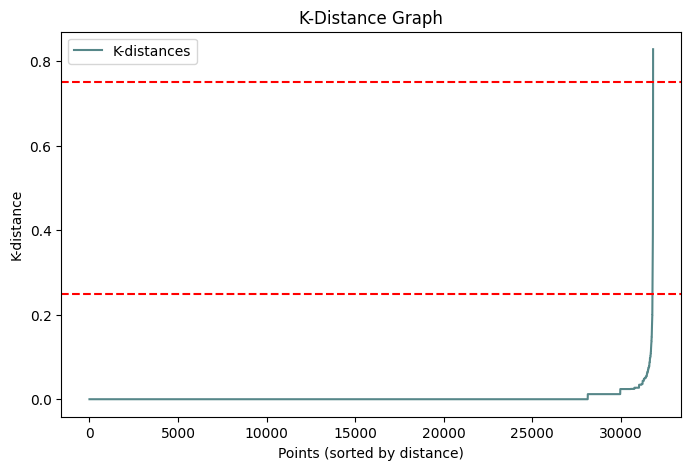

In [163]:
# K-distance graph to find the right eps value
neigh = NearestNeighbors(n_neighbors=80)
neigh.fit(product_data_scaled)
distances, _ = neigh.kneighbors(product_data_scaled)
distances = np.sort(distances[:, -1])  

# Plot the distances
plt.figure(figsize=(8, 5))
plt.plot(distances, label="K-distances", color = "#568789")
plt.axhline(y=0.75, color='red', linestyle='--')
plt.axhline(y=0.25, color='red', linestyle='--')
plt.xlabel("Points (sorted by distance)")
plt.ylabel("K-distance")
plt.title("K-Distance Graph")
plt.legend()
plt.show()

In [165]:
db_results = []

# Define clustering settings
cluster_settings = [
    {"model_type": "dbscan", "eps": k, "algorithm": 'ball_tree'}
    for k in np.arange(0.2, 0.25, 0.1)  
] + [
    {"model_type": "dbscan", "eps": k, "algorithm": 'kd_tree'}
    for k in np.arange(0.2, 0.25, 0.1)
] + [
    {"model_type": "dbscan", "eps": k, "algorithm": 'brute'}
    for k in np.arange(0.2, 0.25, 0.1)
]

# Loop over settings and evaluate models
for settings in cluster_settings:
    result = f.create_and_evaluate_model(df=product_data_scaled, feats=product_data_scaled.columns.tolist(), **settings)
    db_results.append(result)

# Convert results to DataFrame
db_results_df = pd.DataFrame(db_results)
db_results_df

Model  eps  algorithm        R2  Silhouette  Calinski-Harabasz
0  dbscan  0.2  ball_tree  0.024249    0.926245          790.93382
1  dbscan  0.2    kd_tree  0.024249    0.926245          790.93382
2  dbscan  0.2      brute  0.024249    0.926245          790.93382

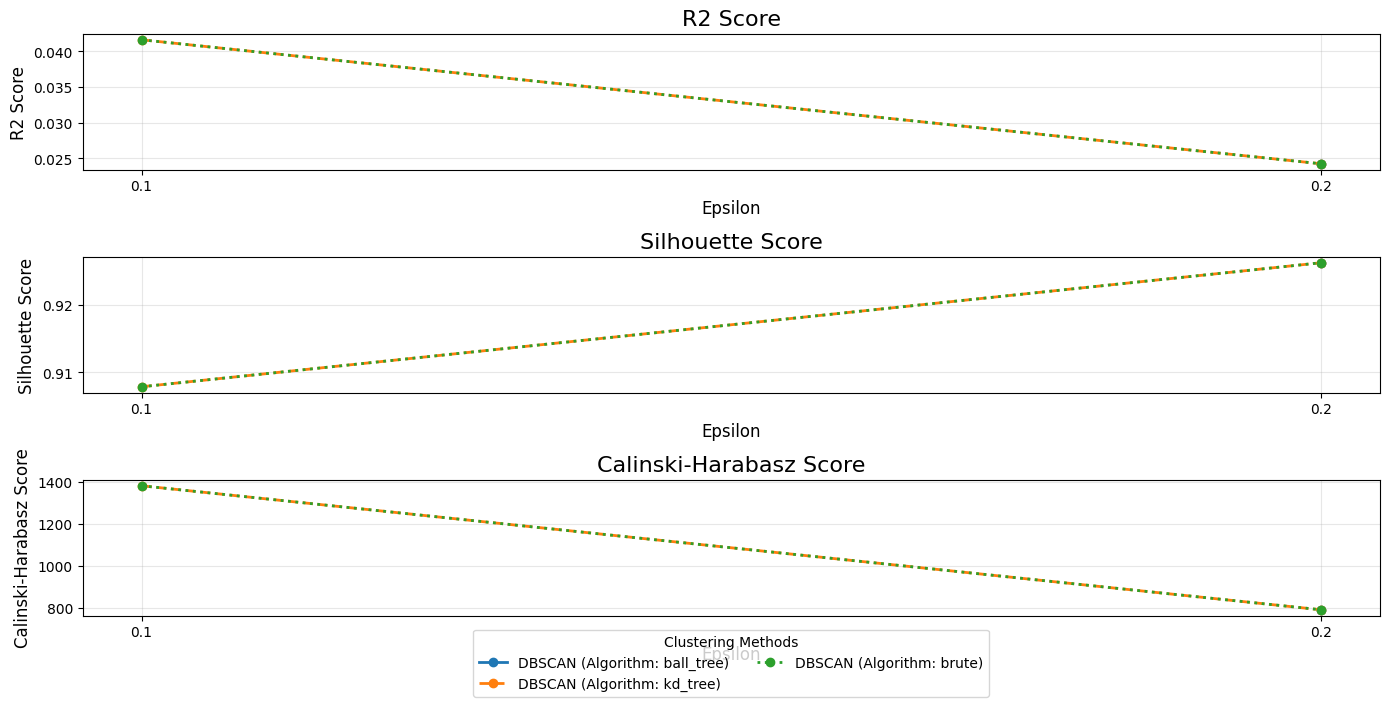

In [59]:
f.plot_evaluation_scores(db_results_df, path+'DBScan_scores')

**Final Model for DBScan**

In [63]:
dbscan = DBSCAN(eps = 0.2)  
dblabels = dbscan.fit_predict(product_data_scaled)

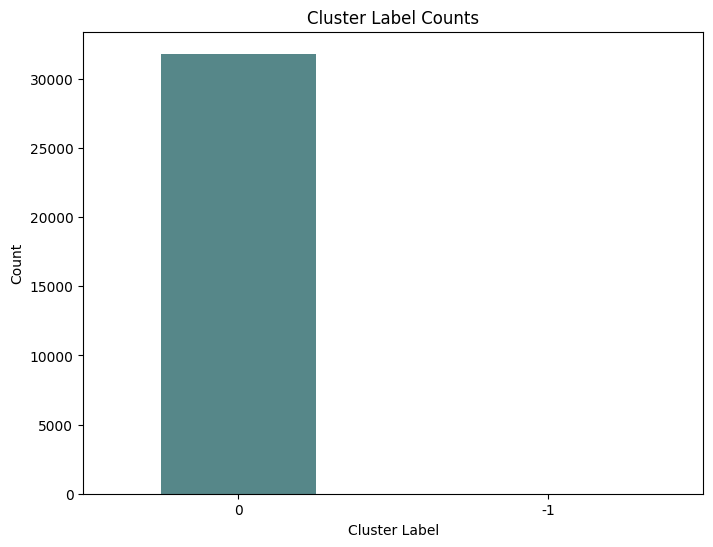

In [64]:
f.plot_counts(dblabels)

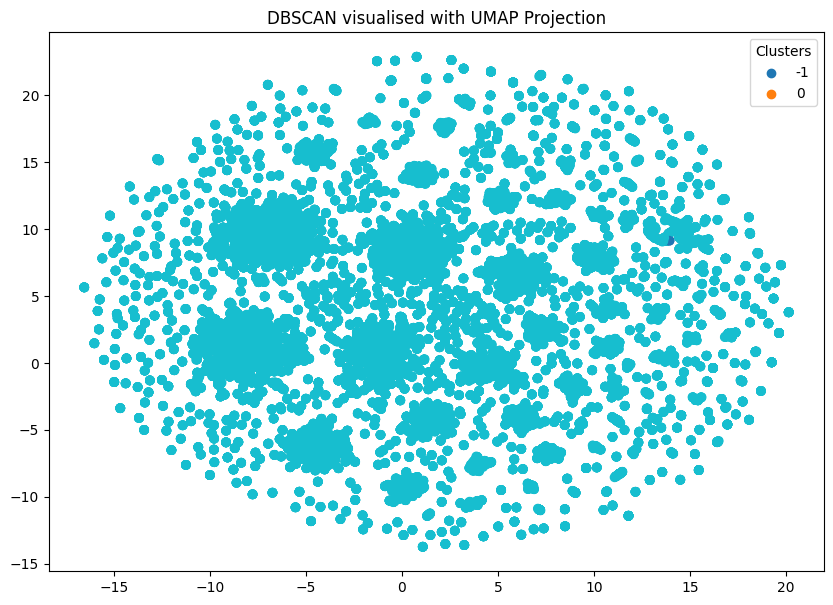

In [176]:
umap_object = umap.UMAP(n_neighbors = 5)
umap_embedding = umap_object.fit_transform(product_data_scaled)

f.plot_dim_reduction(umap_embedding, targets = dblabels,
                   technique = 'DBSCAN visualised with UMAP')

### 2.4.3 HDBScan

<a href="#top">Top &#129033;</a>

To apply **HDBSCAN**, a density-based clustering algorithm, we followed a structured approach to determine the best configuration for our dataset:

**1. Optimizing `min_cluster_size` Parameter**

- The **`min_cluster_size`** parameter controls the smallest cluster size that the algorithm will identify.  
- We tested values for `min_cluster_size` ranging from **5 to 75** in increments of 10 to evaluate its impact on clustering results.

**2. Comparing Cluster Selection Methods**

- HDBSCAN supports two cluster selection methods:  
  - **`eom` (Excess of Mass)**: Focuses on stable clusters.  
  - **`leaf`**: Allows for fine-grained clusters at the leaves of the cluster tree.  
- Both methods were tested for each value of `min_cluster_size` to identify the most effective clustering strategy.

**3. Evaluating Model Performance**

- Each configuration was evaluated using the following metrics:
  - **R² Score**
  - **Silhouette Score**
  - **Calinski-Harabasz Score**

- Results were compiled into a DataFrame for easy comparison.  
- Visualization of these metrics helped pinpoint the best combination of `min_cluster_size` and cluster selection method.

In [67]:
hdb_results = []

# Define clustering settings
cluster_settings = [
    {"model_type": "hdbscan", "min_cluster_size": k, "min_samples": m, "metric": metric, 
     "cluster_selection_method": method, "cluster_selection_epsilon": epsilon}
    for k in range(5, 75, 10)  
    for m in [k // 2, k, k * 2]  
    for metric in ['euclidean', 'manhattan']
    for method in ['leaf', 'eom']
    for epsilon in [0.0, 0.05, 0.1]
]

# Loop over settings and evaluate models
for settings in cluster_settings:
    result = f.create_and_evaluate_model(df=product_data_scaled, feats=product_data_scaled.columns.tolist(), **settings)
    hdb_results.append(result)

# Convert results to DataFrame
hdb_results_df = pd.DataFrame(hdb_results)
hdb_results_df

Model  min_cluster_size  min_samples     metric  \
0    hdbscan                 5            2  euclidean   
1    hdbscan                 5            2  euclidean   
2    hdbscan                 5            2  euclidean   
3    hdbscan                 5            2  euclidean   
4    hdbscan                 5            2  euclidean   
..       ...               ...          ...        ...   
247  hdbscan                65          130  manhattan   
248  hdbscan                65          130  manhattan   
249  hdbscan                65          130  manhattan   
250  hdbscan                65          130  manhattan   
251  hdbscan                65          130  manhattan   

    cluster_selection_method  cluster_selection_epsilon        R2  Silhouette  \
0                       leaf                       0.00  0.720025   -0.381404   
1                       leaf                       0.05  0.100548    0.847366   
2                       leaf                       0.10  0.041827    0.893249   
3                        eom                       0.00  0.945090    0.981026   
4                        eom                       0.05  0.100548    0.847366   
..                       ...                        ...       ...         ...   
247                     leaf                       0.05  0.611644    0.600005   
248                     leaf                       0.10  0.611644    0.600005   
249                      eom                       0.00  0.724362    0.822189   
250                      eom                       0.05  0.611644    0.600005   
251                      eom                       0.10  0.611644    0.600005   

     Calinski-Harabasz  
0           174.978814  
1           711.460676  
2           694.623019  
3          2274.805516  
4           711.460676  
..                 ...  
247       25061.508059  
248       25061.508059  
249        2141.974184  
250       25061.508059  
251       25061.508059  

[252 rows x 9 columns]

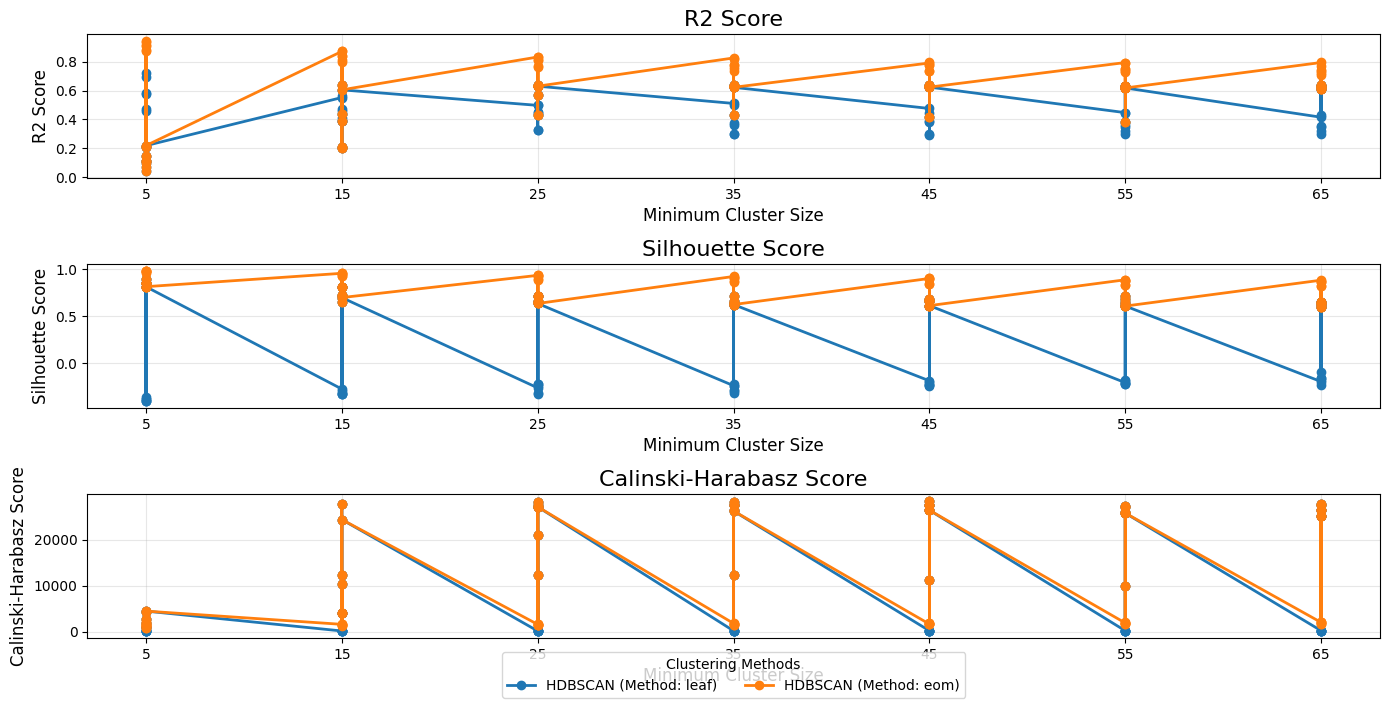

In [68]:
f.plot_evaluation_scores(hdb_results_df, path+'HDBScan_scores')

**Final model for HDBScan**

In [73]:
hdbscan_eom_5 = HDBSCAN(min_cluster_size = 5, 
                  cluster_selection_method = 'eom',
                  min_samples = 2, metric = 'euclidean')

hdblabels_eom_5 = hdbscan_eom_5.fit_predict(product_data_scaled)

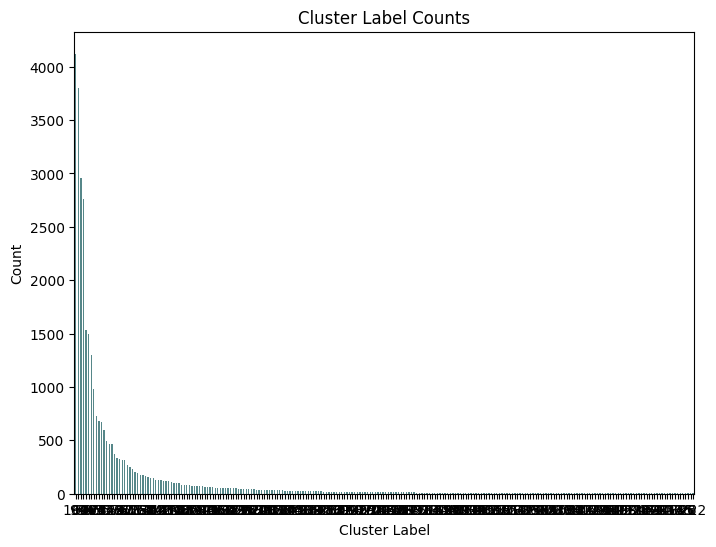

In [74]:
f.plot_counts(hdblabels_eom_5)

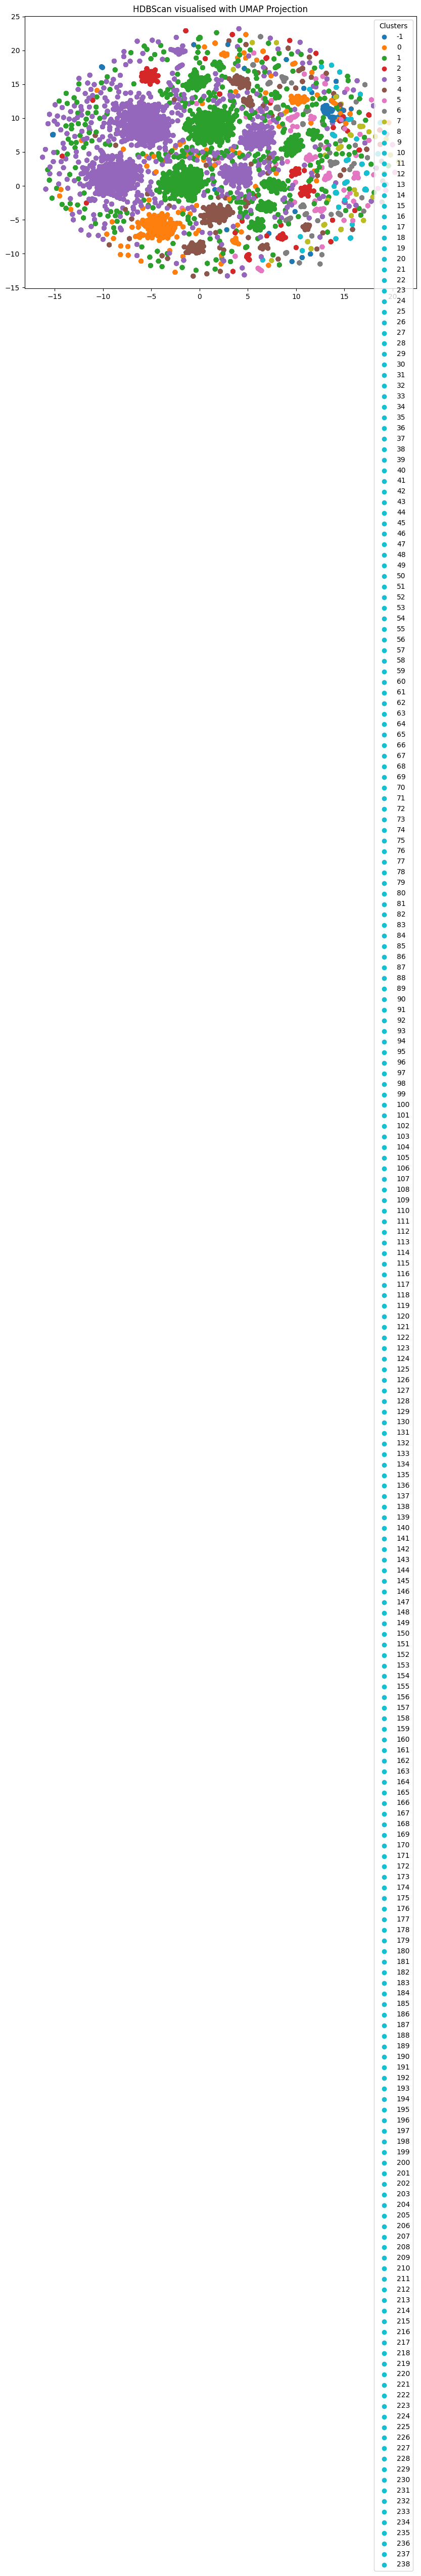

In [177]:
umap_object = umap.UMAP(n_neighbors = 5)
umap_embedding = umap_object.fit_transform(product_data_scaled)

f.plot_dim_reduction(umap_embedding, targets = hdblabels_eom_5,
                   technique = 'HDBScan visualised with UMAP')

## 2.5 Gaussian Mixture Model (GMM)

<a href="#top">Top &#129033;</a>

To achieve an optimal clustering solution using the Gaussian Mixture Model (GMM), the following steps were conducted:

1. Determining the Optimal Range for n_components

- Bayesian Information Criterion (BIC) and Akaike Information Criterion (AIC) were utilized to determine the appropriate range of values for the n_components hyperparameter.
- The ideal range of n_components was identified by observing the points where both metrics indicated a good balance between model complexity and fit quality.

2. Evaluating Different GMM Configurations
- Within the identified range of n_components, multiple GMM configurations were evaluated, considering different combinations of the following hyperparameters:

    - n_components: Number of mixture components (clusters), varying between 7 and 14.
    - covariance_type: Specifies the covariance structure of the Gaussian components, including: full, tied, diag, spherical
    - init_params: Initialization method for the model parameters, using 'kmeans' initialization in this case.

3. Evaluating Model Performance

    - Each GMM configuration was assessed using clustering quality metrics and the distribution of data points across the clusters.
    - The results were compiled into a structured DataFrame for easy comparison.

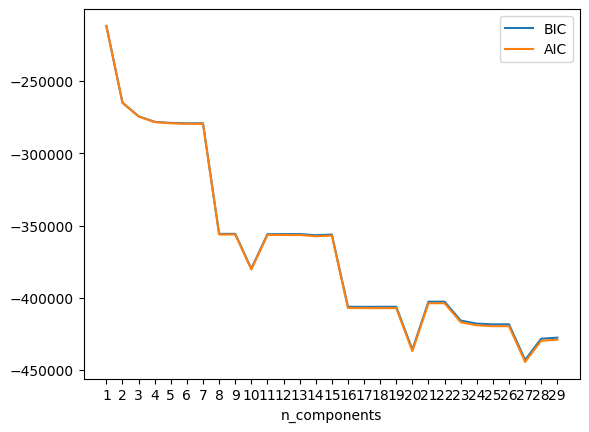

In [197]:
n_components = np.arange(1, 30)
models = [GaussianMixture(n, random_state=1).fit(product_data_scaled)
          for n in n_components]

bic_values = [m.bic(product_data_scaled) for m in models]
aic_values = [m.aic(product_data_scaled) for m in models]
plt.plot(n_components, bic_values, label='BIC')
plt.plot(n_components, aic_values, label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components')
plt.xticks(n_components)
plt.show()

In [198]:
gmm_results = []
covariance_lst = ['full', 'tied', 'diag', 'spherical']

# Define clustering settings
cluster_settings = [
    {"model_type": "gmm", "n_components": k, "covariance_type": cov, 'init_params': 'kmeans'}
    for k in range(7, 14)  
    for cov in covariance_lst
]

# Loop over settings and evaluate models
for settings in cluster_settings:
    result = f.create_and_evaluate_model(df=product_data_scaled, feats=product_data_scaled.columns.tolist(), **settings)
    gmm_results.append(result)

# Convert results to DataFrame
gmm_results_df = pd.DataFrame(gmm_results)
gmm_results_df

Model  n_components covariance_type init_params        R2  Silhouette  \
0    gmm             7            full      kmeans  0.824693    0.424533   
1    gmm             7            tied      kmeans  0.671989    0.547485   
2    gmm             7            diag      kmeans  0.810670    0.441787   
3    gmm             7       spherical      kmeans  0.837263    0.401935   
4    gmm             8            full      kmeans  0.846493    0.432139   
5    gmm             8            tied      kmeans  0.822938    0.539356   
6    gmm             8            diag      kmeans  0.831925    0.446440   
7    gmm             8       spherical      kmeans  0.859806    0.436377   
8    gmm             9            full      kmeans  0.858898    0.467494   
9    gmm             9            tied      kmeans  0.767965    0.588855   
10   gmm             9            diag      kmeans  0.853200    0.368166   
11   gmm             9       spherical      kmeans  0.866769    0.451593   
12   gmm            10            full      kmeans  0.867351    0.473275   
13   gmm            10            tied      kmeans  0.756662    0.525619   
14   gmm            10            diag      kmeans  0.845338    0.449232   
15   gmm            10       spherical      kmeans  0.884434    0.451273   
16   gmm            11            full      kmeans  0.888067    0.467958   
17   gmm            11            tied      kmeans  0.784092    0.491223   
18   gmm            11            diag      kmeans  0.888119    0.471642   
19   gmm            11       spherical      kmeans  0.891281    0.440502   
20   gmm            12            full      kmeans  0.894043    0.471104   
21   gmm            12            tied      kmeans  0.806824    0.530005   
22   gmm            12            diag      kmeans  0.894099    0.465236   
23   gmm            12       spherical      kmeans  0.898040    0.455405   
24   gmm            13            full      kmeans  0.884692    0.462793   
25   gmm            13            tied      kmeans  0.822353    0.530032   
26   gmm            13            diag      kmeans  0.902394    0.472473   
27   gmm            13       spherical      kmeans  0.907014    0.437248   

    Calinski-Harabasz  
0        24949.120487  
1        13038.596929  
2        22708.365341  
3        27285.913510  
4        25066.681131  
5        24649.222387  
6        22500.031526  
7        27878.637754  
8        24210.515267  
9        15044.915271  
10       23116.406904  
11       25875.884742  
12       23116.388889  
13       14134.937749  
14       19323.085437  
15       27056.006456  
16       25243.297508  
17       12838.953910  
18       25256.672767  
19       26083.522593  
20       24405.178284  
21       14765.783178  
22       24419.469055  
23       25475.329816  
24       20341.564844  
25       14728.517122  
26       24511.564083  
27       25861.212391

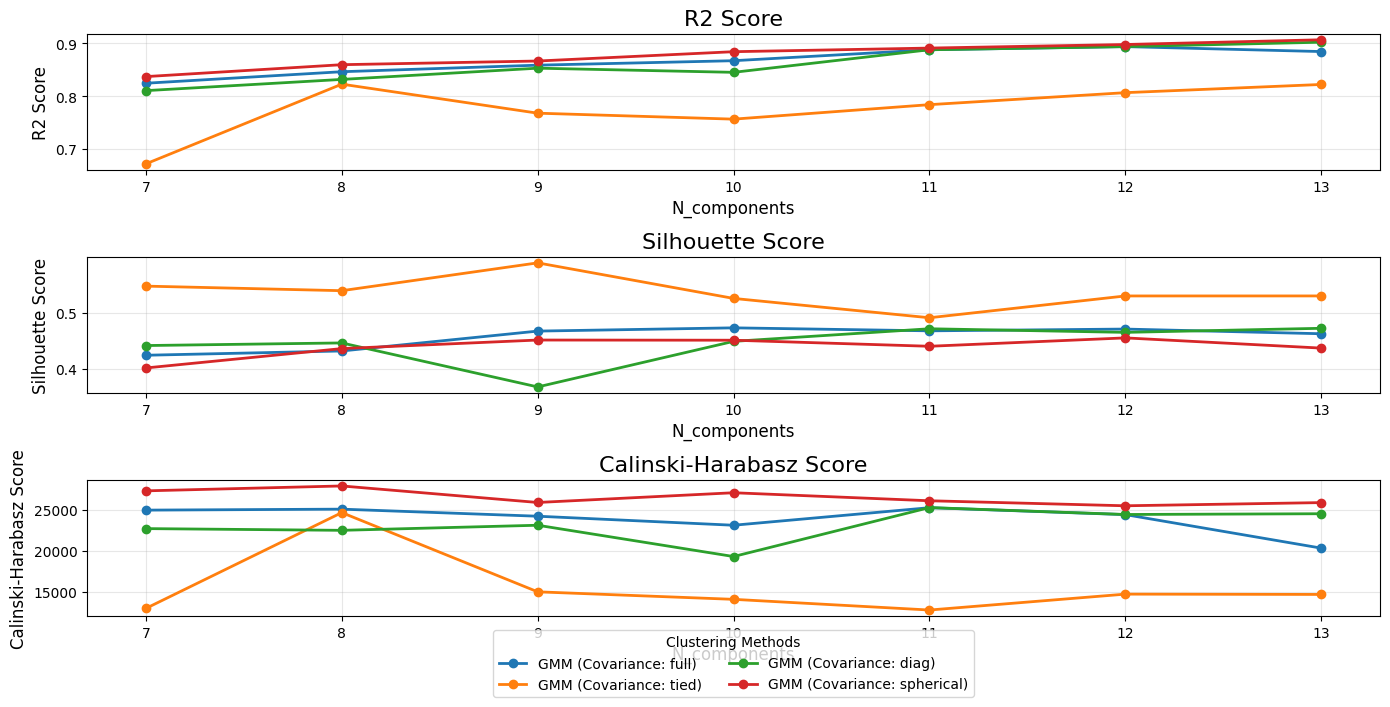

In [199]:
f.plot_evaluation_scores(gmm_results_df, path+'gmm')

**Final Model for GMM**

In [200]:
gmm = GaussianMixture(random_state = 1, covariance_type = 'spherical',
                     n_components = 8)

gmm_labels = gmm.fit_predict(product_data_scaled)

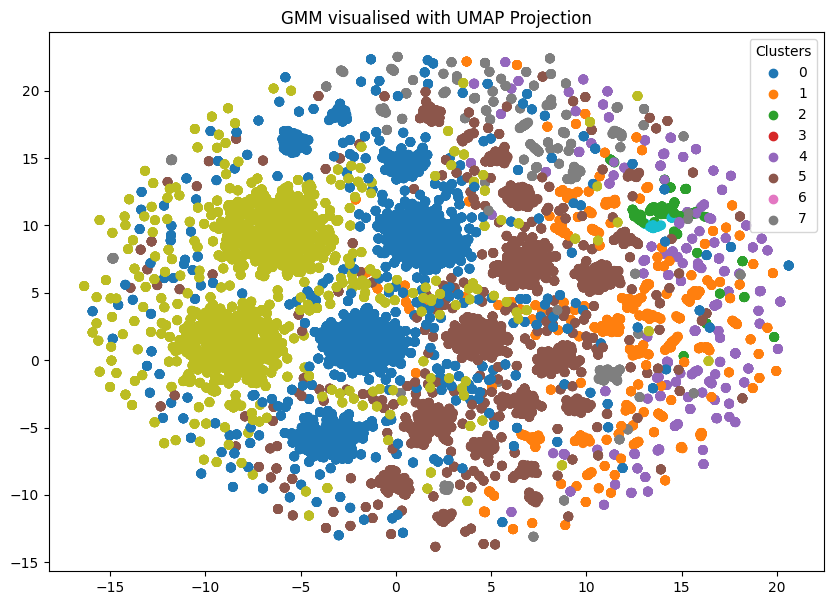

In [201]:
umap_object = umap.UMAP(n_neighbors = 5)
umap_embedding = umap_object.fit_transform(product_data_scaled)

f.plot_dim_reduction(umap_embedding, targets = gmm_labels,
                   technique = 'GMM visualised with UMAP')

# 3. Model Combination

<a href="#top">Top &#129033;</a>

In [107]:
scaled_data_copy = product_data_scaled.copy()
scaled_data_array_copy = scaled_data_array.copy()

## 3.1 SOM + K-Means

<a href="#top">Top &#129033;</a>

Get Best Matching Units and convert their coordinater to features

In [108]:
som_labels = np.array([som.winner(x) for x in scaled_data_array_copy])

som_features = np.array([som.get_weights()[x[0], x[1]].flatten() for x in som_labels])

Apply K-Means in the SOM features

In [109]:
dispersion = []
for k in range(1, 20):
    kmeans = KMeans(n_clusters=k, random_state=24, max_iter=500, n_init=50).fit(som_features)
    dispersion.append(kmeans.inertia_)
    

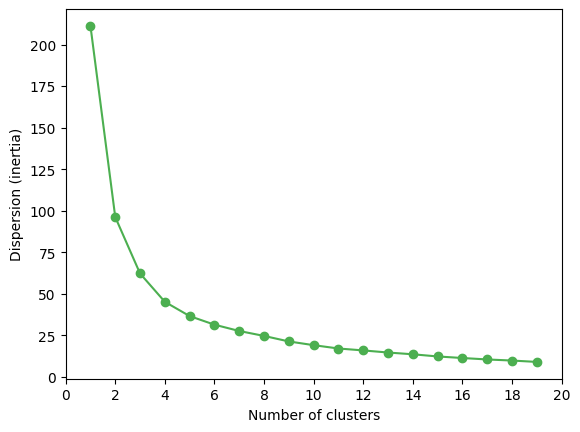

In [110]:
plt.plot(range(1, 20), dispersion, marker='o', color='#4CAF50')
plt.xlabel('Number of clusters')
plt.ylabel('Dispersion (inertia)')
plt.xticks(np.arange(0, 21, step=2))  
# plt.vlines(7, 5000, 600000, color='red')

plt.show()

In [118]:
number_clusters = 4
kmclust4_som = KMeans(n_clusters=number_clusters, 
                 random_state=24, max_iter=500, n_init=50)

In [119]:
som_kmeans_labels4 = kmclust4_som.fit_predict(som_features)

In [120]:
feats = scaled_data_copy.columns.to_list()

r2, silhouette, calinski_harabasz = f.cluster_evaluation(scaled_data_copy, 
                                                       feats, som_kmeans_labels4)

print(f'R2 for SOM+K-Means: {r2}')
print(f'Silhouette Score for SOM+K-Means: {silhouette}')
print(f'Calinski Harabasz Index for SOM+K-Means: {calinski_harabasz}')

R2 for SOM+K-Means: [0.77412677]
Silhouette Score for SOM+K-Means: [0.52391742]
Calinski Harabasz Index for SOM+K-Means: [36356.39721131]


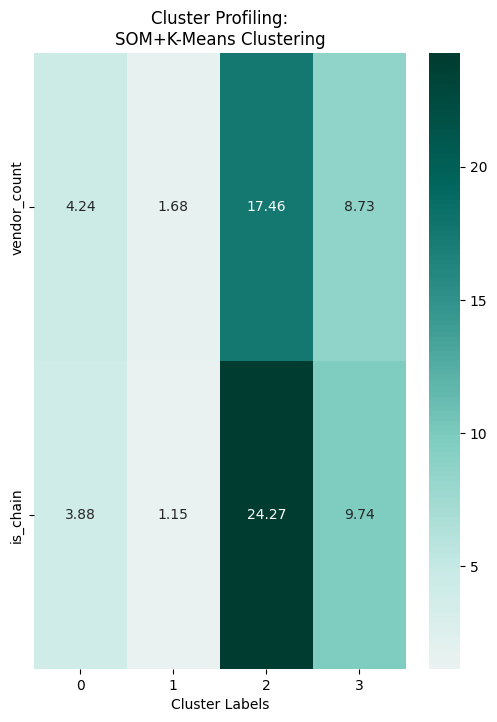

In [121]:
f.plot_cluster_profiling(product_data, som_kmeans_labels4, "SOM+K-Means")

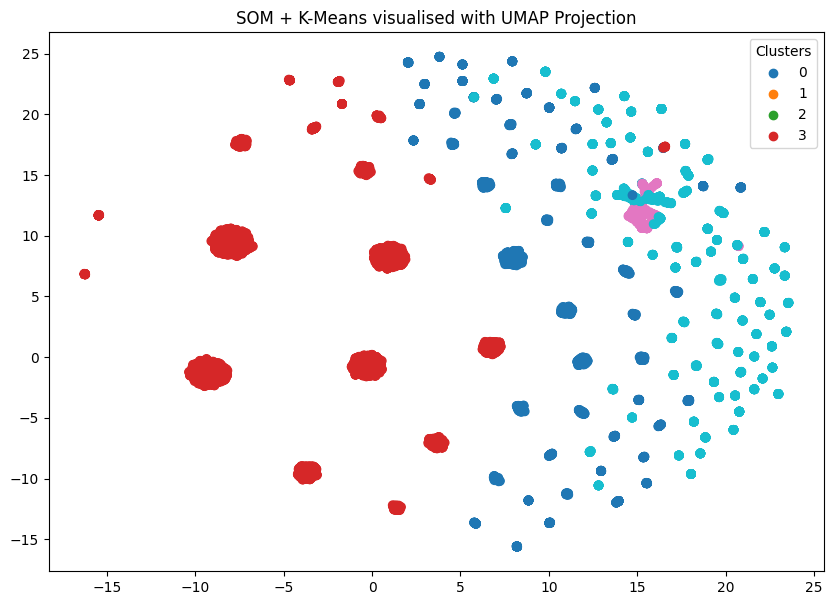

In [180]:
umap_object = umap.UMAP(n_neighbors = 10)
umap_embedding = umap_object.fit_transform(product_data_scaled)

f.plot_dim_reduction(umap_embedding, targets = som_kmeans_labels4,
                   technique = 'SOM + K-Means visualised with UMAP')

# 4. Model Comparison

<a href="#top">Top &#129033;</a>

Export and Import Result Dataframes

In [125]:
hr_results_df.to_csv('./result_dfs/hr_results_df.csv')
results_kmeans_df.to_csv('./result_dfs/results_kmeans_df.csv')

In [129]:
dfs = [hr_results_df, results_kmeans_df]
results_df = pd.concat(dfs)
results_df.reset_index()

index         Model  n_clusters   linkage     metric        R2  \
0       0  hierarchical           2  complete  euclidean  0.114591   
1       1  hierarchical           3  complete  euclidean  0.144751   
2       2  hierarchical           4  complete  euclidean  0.149589   
3       3  hierarchical           5  complete  euclidean  0.370804   
4       4  hierarchical           6  complete  euclidean  0.373371   
5       5  hierarchical           7  complete  euclidean  0.377546   
6       6  hierarchical           2      ward  euclidean  0.516790   
7       7  hierarchical           3      ward  euclidean  0.681251   
8       8  hierarchical           4      ward  euclidean  0.752516   
9       9  hierarchical           5      ward  euclidean  0.795664   
10     10  hierarchical           2  complete         l1  0.128064   
11     11  hierarchical           3  complete         l1  0.132726   
12     12  hierarchical           4  complete         l1  0.136703   
13     13  hierarchical           5  complete         l1  0.262540   
14      0        kmeans           3       NaN        NaN  0.704553   
15      1        kmeans           4       NaN        NaN  0.777788   
16      2        kmeans           5       NaN        NaN  0.820483   
17      3        kmeans           6       NaN        NaN  0.842477   
18      4        kmeans           7       NaN        NaN  0.859514   

    Silhouette  Calinski-Harabasz  random_state  max_iter  n_init  
0     0.873319        4118.960048           NaN       NaN     NaN  
1     0.817022        2693.193132           NaN       NaN     NaN  
2     0.816896        1865.971346           NaN       NaN     NaN  
3     0.785406        4688.563994           NaN       NaN     NaN  
4     0.784796        3792.166133           NaN       NaN     NaN  
5     0.784732        3216.803278           NaN       NaN     NaN  
6     0.654405       34037.709789           NaN       NaN     NaN  
7     0.631789       34009.153243           NaN       NaN     NaN  
8     0.479276       32255.293773           NaN       NaN     NaN  
9     0.482328       30978.835573           NaN       NaN     NaN  
10    0.879099        4674.402960           NaN       NaN     NaN  
11    0.872704        2435.212126           NaN       NaN     NaN  
12    0.870757        1679.777316           NaN       NaN     NaN  
13    0.815947        2832.293816           NaN       NaN     NaN  
14    0.593857       37946.493591          42.0     500.0    50.0  
15    0.515994       37130.188216          42.0     500.0    50.0  
16    0.499430       36361.681145          42.0     500.0    50.0  
17    0.484531       34038.651267          42.0     500.0    50.0  
18    0.486435       32447.512690          42.0     500.0    50.0

In [ ]:
# f.plot_evaluation_scores(results_df, path+'all')

In [130]:
def create_configuration(row):
    if not pd.isna(row.get('n_clusters', None)):
        return f"{row['Model']} (n_clusters={row['n_clusters']})"
    elif not pd.isna(row.get('eps', None)):
        return f"{row['Model']} (eps={row['eps']})"
    elif not pd.isna(row.get('min_cluster_size', None)):
        return f"{row['Model']} (min_cluster_size={row['min_cluster_size']})"
    else:
        return row['Model']

results_df['Configuration'] = results_df.apply(create_configuration, axis=1)

# Reshape the DataFrame into long format
metrics = ['R2', 'Silhouette', 'Calinski-Harabasz']
df_melted = results_df.melt(
    id_vars=['Configuration'],  # Use combined configurations
    value_vars=metrics,
    var_name='Metric',
    value_name='Value'
)


In [131]:
df_melted

Configuration             Metric         Value
0   hierarchical (n_clusters=2)                 R2      0.114591
1   hierarchical (n_clusters=3)                 R2      0.144751
2   hierarchical (n_clusters=4)                 R2      0.149589
3   hierarchical (n_clusters=5)                 R2      0.370804
4   hierarchical (n_clusters=6)                 R2      0.373371
5   hierarchical (n_clusters=7)                 R2      0.377546
6   hierarchical (n_clusters=2)                 R2      0.516790
7   hierarchical (n_clusters=3)                 R2      0.681251
8   hierarchical (n_clusters=4)                 R2      0.752516
9   hierarchical (n_clusters=5)                 R2      0.795664
10  hierarchical (n_clusters=2)                 R2      0.128064
11  hierarchical (n_clusters=3)                 R2      0.132726
12  hierarchical (n_clusters=4)                 R2      0.136703
13  hierarchical (n_clusters=5)                 R2      0.262540
14        kmeans (n_clusters=3)                 R2      0.704553
15        kmeans (n_clusters=4)                 R2      0.777788
16        kmeans (n_clusters=5)                 R2      0.820483
17        kmeans (n_clusters=6)                 R2      0.842477
18        kmeans (n_clusters=7)                 R2      0.859514
19  hierarchical (n_clusters=2)         Silhouette      0.873319
20  hierarchical (n_clusters=3)         Silhouette      0.817022
21  hierarchical (n_clusters=4)         Silhouette      0.816896
22  hierarchical (n_clusters=5)         Silhouette      0.785406
23  hierarchical (n_clusters=6)         Silhouette      0.784796
24  hierarchical (n_clusters=7)         Silhouette      0.784732
25  hierarchical (n_clusters=2)         Silhouette      0.654405
26  hierarchical (n_clusters=3)         Silhouette      0.631789
27  hierarchical (n_clusters=4)         Silhouette      0.479276
28  hierarchical (n_clusters=5)         Silhouette      0.482328
29  hierarchical (n_clusters=2)         Silhouette      0.879099
30  hierarchical (n_clusters=3)         Silhouette      0.872704
31  hierarchical (n_clusters=4)         Silhouette      0.870757
32  hierarchical (n_clusters=5)         Silhouette      0.815947
33        kmeans (n_clusters=3)         Silhouette      0.593857
34        kmeans (n_clusters=4)         Silhouette      0.515994
35        kmeans (n_clusters=5)         Silhouette      0.499430
36        kmeans (n_clusters=6)         Silhouette      0.484531
37        kmeans (n_clusters=7)         Silhouette      0.486435
38  hierarchical (n_clusters=2)  Calinski-Harabasz   4118.960048
39  hierarchical (n_clusters=3)  Calinski-Harabasz   2693.193132
40  hierarchical (n_clusters=4)  Calinski-Harabasz   1865.971346
41  hierarchical (n_clusters=5)  Calinski-Harabasz   4688.563994
42  hierarchical (n_clusters=6)  Calinski-Harabasz   3792.166133
43  hierarchical (n_clusters=7)  Calinski-Harabasz   3216.803278
44  hierarchical (n_clusters=2)  Calinski-Harabasz  34037.709789
45  hierarchical (n_clusters=3)  Calinski-Harabasz  34009.153243
46  hierarchical (n_clusters=4)  Calinski-Harabasz  32255.293773
47  hierarchical (n_clusters=5)  Calinski-Harabasz  30978.835573
48  hierarchical (n_clusters=2)  Calinski-Harabasz   4674.402960
49  hierarchical (n_clusters=3)  Calinski-Harabasz   2435.212126
50  hierarchical (n_clusters=4)  Calinski-Harabasz   1679.777316
51  hierarchical (n_clusters=5)  Calinski-Harabasz   2832.293816
52        kmeans (n_clusters=3)  Calinski-Harabasz  37946.493591
53        kmeans (n_clusters=4)  Calinski-Harabasz  37130.188216
54        kmeans (n_clusters=5)  Calinski-Harabasz  36361.681145
55        kmeans (n_clusters=6)  Calinski-Harabasz  34038.651267
56        kmeans (n_clusters=7)  Calinski-Harabasz  32447.512690

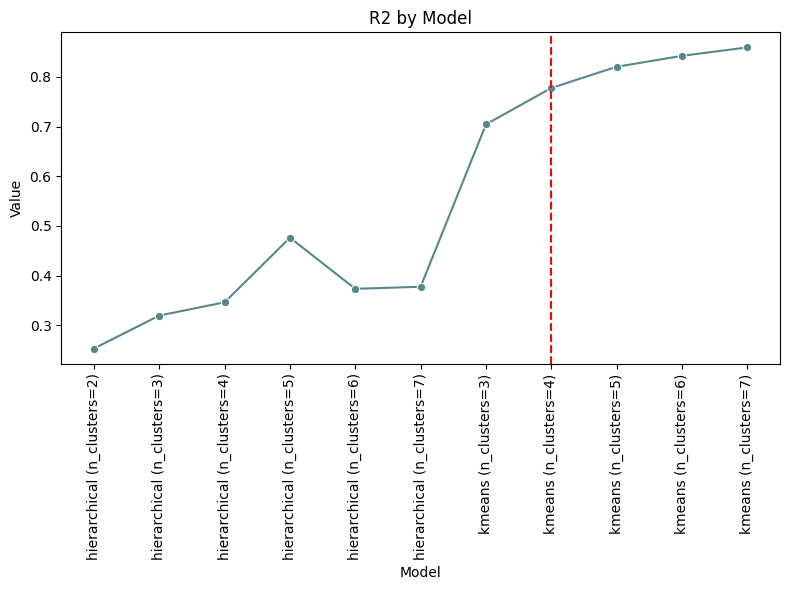

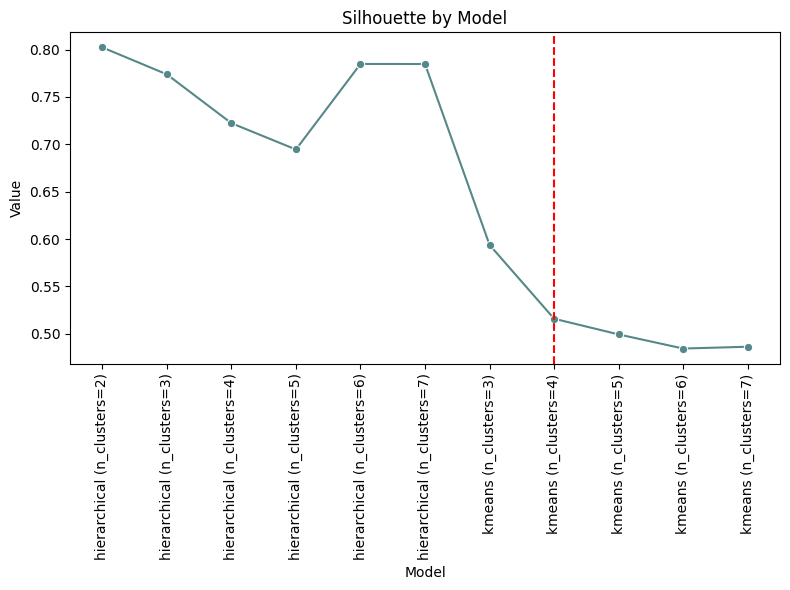

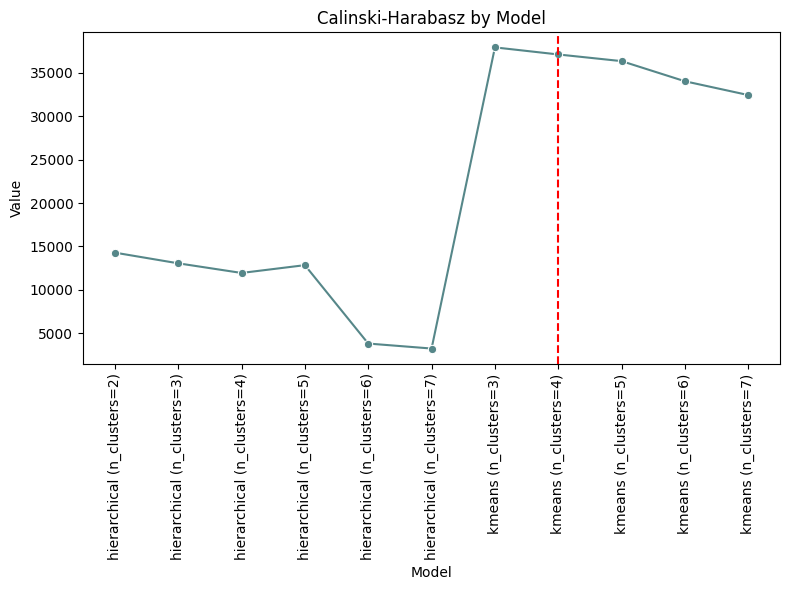

In [161]:
import matplotlib.pyplot as plt
import seaborn as sns

def model_comparison(df_melted, metrics, model_for_line, line_color='red', line_style='--', marker='o', figsize=(8, 6)):
    """
    Plot line charts for different metrics and add a vertical line at the specified model.

    Parameters:
    - df_melted: DataFrame containing the melted data.
    - metrics: List of metrics to plot (e.g., ['R2', 'Silhouette', 'Calinski-Harabasz']).
    - model_for_line: The model name where you want to add the vertical line.
    - line_color: Color for the vertical line (default is 'red').
    - line_style: Line style for the vertical line (default is dashed '--').
    - marker: Marker style for the line plot (default is 'o').
    - figsize: Figure size for the plot (default is (8, 6)).
    """
    # Iterate over each metric and create a separate plot
    for metric in metrics:
        # Filter data for the current metric
        data_metric = df_melted[df_melted['Metric'] == metric]

        # Create a new figure for each metric
        plt.figure(figsize=figsize)

        # Plot the data with a specific line color and no legend
        sns.lineplot(
            data=data_metric,
            x='Configuration',
            y='Value',
            marker=marker,
            color='#568789',  
            legend=False,
            ci=None
        )

        # Add the vertical line at the specified model
        plt.axvline(x=model_for_line, color=line_color, linestyle=line_style, label=f'{model_for_line} (Vertical Line)')

        # Remove the grid
        plt.grid(False)

        # Set title and labels
        plt.title(f'{metric} by Model')
        plt.xlabel('Model')
        plt.ylabel('Value')
        plt.xticks(rotation=90)  # Rotate x-axis labels for better readability

        # Adjust the layout for each individual plot
        plt.tight_layout()

        # Show the plot
        plt.show()

# Example of calling the function:
metrics = ['R2', 'Silhouette', 'Calinski-Harabasz']
model_for_line = 'kmeans (n_clusters=4)'  
model_comparison(df_melted, metrics, model_for_line)

**Final Solution**

In [145]:
product_data['product_data_labels'] = som_kmeans_labels4

In [155]:
cluster_summary = product_data.groupby('product_data_labels').mean()
print(cluster_summary)

                     vendor_count   is_chain
product_data_labels                         
0                        4.244060   3.882007
1                        1.676311   1.148166
2                       17.457831  24.271084
3                        8.727344   9.743499


In [153]:
product_data.to_csv('./data/labels/product_data.csv')